作业介绍：

本次作业的目的如下：
- 实现表格型Q学习算法
- 熟悉用于强化学习的 gym 环境用法

gym环境的使用在后面作业中将用到，因此建议认真阅读后面的代码。若在实现表格型Q算法过程中遇到关于gym的使用问题，也可以先跳转到后面的内容。

In [52]:
# 首先安装必要的包
!pip install gym[atari]==0.12.6 JSAnimation

Looking in indexes: https://pypi.mirrors.ustc.edu.cn/simple/


# 使用Q学习解决出租车问题

## 出租车问题

在出租车问题中，智能体的目标是在一个地方选择乘客并在另一个地方放下乘客。
- 智能体成功落客获得+20分，而每走一步都会损失1分。
- 非法接送会被罚10分。

## 使用gym仿真出租车问题

`gym`是一个OpenAI开发的开源工具包，包含多种模拟环境，用于训练智能体和开发新的强化学习算法。出租车问题在`gym`中可以用名为`Taxi-v2`的环境仿真。具体仿真代码如下：

In [53]:
import gym

# 生成仿真环境
env = gym.make('Taxi-v2')
# 重置仿真环境
obs = env.reset()
# 渲染环境当前状态
env.render()

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



在上述仿真环境渲染输出中，状态空间的墙壁由|表示，四个位置标记分别为R，G，Y和B。出租车用黄色方框表示。位置R是上客位置，G是落客位置。

`Taxi-v2`环境有500种可能的状态和6种可能的动作。

In [54]:
m = env.observation_space.n  # size of the state space
n = env.action_space.n  # size of action space

print("出租车问题状态数量为{:d}，动作数量为{:d}。".format(m, n))

出租车问题状态数量为500，动作数量为6。


## 表格式Q学习

Q学习的目标是学习最优的动作选择策略。给定一个特定的状态$s$，并选择特定的动作$a$，Q学习尝试学习状态$s$的价值。在最简单的版本中，Q学习可以用查找表实现。我们在环境中为每一个状态（行）和动作（列）维护一个价值表。

### 贝尔曼方程

我们首先将Q表中的所有条目初始化为0以保证所有状态机会均等。之后，我们观察通过采取特定行动获得的回报以更新Q表。借助贝尔曼方程（the Bellman Equation)动态更新Q表：
$$Q(s_t, a_t) = (1 - \alpha)Q(s_t, a_t) + \alpha (r_t + \gamma \max_{a} Q(s_{t+1}, a_t))$$
这里，$\alpha$是学习率。

### 探索-利用的权衡

如何选择下一步的动作？有两种方案；
- 一是随机选择动作。这使智能体以相同的概率探索所有可能的动作，这样做的同时也忽略了它已经学到的信息。
- 二是选择值最大的动作。最初所有动作都具有相同的Q值；但是随着智能体的学习，某些动作将获得高价值而其他动作将获得低价值。这时，智能体正在利用它已经学到的知识。

那么是探索还是利用更好？这被称为探索-利用权衡。解决这个问题的一种自然方式是依靠智能体学到的东西，但有时候只是探索。这可以通过使用**$\epsilon$-贪婪算法**实现。其基本思想是智能体以概率$\epsilon$随机选择动作，并利用概率$(1-\epsilon)$利用先前剧集中学到的信息。该算法在大多数时间$(1-\epsilon)$选择最佳选项（贪婪），但有时$(\epsilon)$它做随机选择。

以下是算法超参数部分。

In [55]:
import numpy as np

# Intialize the Q-table and hyperparameters
# Q表，大小为 m*n
Q = np.zeros([m,n])
# 回报的折扣率
gamma = 0.97
# 分幕式训练中最大幕数
max_episode = 1000
# 每一幕最长步数
max_steps = 100
# 学习率参数
alpha = 0.7
# 随机探索概率
epsilon = 0.3

下面让我们实现表格式的Q学习。可能用到的主要函数包括：

- 基于随机采样(探索)的动作选择 `a=env.action_space.sample()`
- 基于最优值（贪婪）的动作选择 `a=np.argmax(Q[s, :])`，其中`Q[s, :]`是状态为`s`时各动作的价值。

`numpy`中可能用到的两个重要函数有：
- `np.max(data)`求数组`data`中的最大值；
- `np.argmax(data)`求数组`data`中最大值所在位置的索引。
- `np.any(data)`数组中`data`中任意一个元素不为假。对于整型数组，任意一个元素不为0时函数返回True。

In [56]:
for i in range(max_episode):
    # Start with new environment
    s = env.reset()
    done = False
    counter = 0
    for _ in range(max_steps):
        # Choose an action using epsilon greedy policy
        p = np.random.rand()
        # 请根据 epsilon-贪婪算法 选择动作 a
        # p > epsilon 或尚未学习到某个状态的价值时，随机探索
        # 其它情况，利用已经觉得的价值函数进行贪婪选择 (np.argmax)
        # ======= 将代码补充到这里
        if p > epsilon or not np.any(Q[s:]):
            a=env.action_space.sample()
        else:
            a=np.argmax(Q[s, :])
        # ======= 补充代码结束
        
        # 返回新的状态、回报、以及是否完成
        s_new, r, done, _ = env.step(a)
        # 请根据贝尔曼方程，更新Q表 (np.max)
        # ======= 将代码补充到这里
        Q[s,a] = (1-alpha)*Q[s,a]+alpha*(r+gamma*np.max(Q[s_new,:]))
        # ======= 补充代码结束
        print(Q[s,a],r)
        s = s_new
        if done:
            break

学习得到的策略存储在表格Q中。根据Q表示的价值函数，我们可以在每一个状态确定一下回报最大的动作。现在让我们看看学到的智能体表现如何。

In [57]:
s = env.reset()
done = False
env.render()
# Test the learned Agent
for i in range(max_steps):
    a = np.argmax(Q[s,:])
    s, _, done, _ = env.step(a)
    env.render()
    if done:
        break

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (West)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
|_: : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| :_: : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : :_: : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: |_: :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | :_:G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (East)
+---------+
|R: | : :G|
| : : : : |
| : : : : |
| | : | : |
|Y| : |B: |
+

### 性能评估

请在上面单次评估的基础上，编写代码统计100次随机测试的平均回报及回报的方差。

提示：可以不调用`env.render()`展示环境的状态。

In [58]:
rewards = []
# ======= 将代码补充到这里
for i in range(100):
    s = env.reset()
    done = False
    # Test the learned Agent
    for i in range(max_steps):
        a = np.argmax(Q[s,:])
        s, r, done, _ = env.step(a)
        rewards.append(r)
        if done:
            break
r_mean = np.mean(rewards)
r_var = np.var(rewards)
# ======= 补充代码结束

print("平均回报为{}，回报的方差为{}。".format(r_mean, r_var))
env.close()

平均回报为0.7269736842105263，回报的方差为33.284009262465375。


### 超参数对性能的影响

请尝试修改各个超参数，以充分了解各个超参数对表格型Q学习算法的影响。尤其是贪婪概率`epsilon`与学习率`alpha`。

如何修改超参数可以得到更大的平均回报？

答：提高学习率alpha、降低贪婪概率epsilon、提高回报折扣率gamma，可以得到更大的平均回报。

# gym环境的用法

## 列出所有环境的名称

In [59]:
from gym import envs
names = [env.id for env in envs.registry.all()]
print('\n'.join(names))

Copy-v0
RepeatCopy-v0
ReversedAddition-v0
ReversedAddition3-v0
DuplicatedInput-v0
Reverse-v0
CartPole-v0
CartPole-v1
MountainCar-v0
MountainCarContinuous-v0
Pendulum-v0
Acrobot-v1
LunarLander-v2
LunarLanderContinuous-v2
BipedalWalker-v2
BipedalWalkerHardcore-v2
CarRacing-v0
Blackjack-v0
KellyCoinflip-v0
KellyCoinflipGeneralized-v0
FrozenLake-v0
FrozenLake8x8-v0
CliffWalking-v0
NChain-v0
Roulette-v0
Taxi-v2
GuessingGame-v0
HotterColder-v0
Reacher-v2
Pusher-v2
Thrower-v2
Striker-v2
InvertedPendulum-v2
InvertedDoublePendulum-v2
HalfCheetah-v2
HalfCheetah-v3
Hopper-v2
Hopper-v3
Swimmer-v2
Swimmer-v3
Walker2d-v2
Walker2d-v3
Ant-v2
Ant-v3
Humanoid-v2
Humanoid-v3
HumanoidStandup-v2
FetchSlide-v1
FetchPickAndPlace-v1
FetchReach-v1
FetchPush-v1
HandReach-v0
HandManipulateBlockRotateZ-v0
HandManipulateBlockRotateZTouchSensors-v0
HandManipulateBlockRotateZTouchSensors-v1
HandManipulateBlockRotateParallel-v0
HandManipulateBlockRotateParallelTouchSensors-v0
HandManipulateBlockRotateParallelTouchSen

## 创建和渲染（可视化）环境

要创建环境，可以使用`make`命令，将环境名称作为字符串传入。如创建`Pong`环境，需要传递的参数`Pong-v0`。方法`reset`使环境返回初始状态。`Pong`环境的状态空间为$210 \times 160 \times 3$的数组，可以展示为一幅彩色图像。在`Jupyter notebook`中，可以使用`matplotlib`以内联方式展示环境的状态空间。具体代码如下：

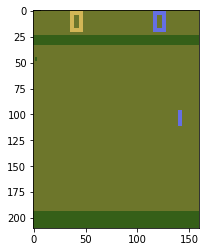

In [60]:
import gym
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make('Pong-v0')
obs = env.reset()
plt.imshow(env.render(mode='rgb_array'))
plt.show()

我们可以使用以下代码将每个时间步的状态存储在一个数组`video` 。

In [61]:
env = gym.make('Pong-v0')
obs = env.reset()
video = [] # array to store state space at each step
n_frames = 300
for _ in range(n_frames):
    video.append(env.render(mode='rgb_array'))
    obs, reward, done, _ = env.step(env.action_space.sample())
    if done:
        break

借助matplotlib和IPython中的动画功能，这些帧可以在Jupyter笔记本中显示为连续播放的GIF风格图像。

尝试执行下面的代码，画面展示后需要点击播放按钮。


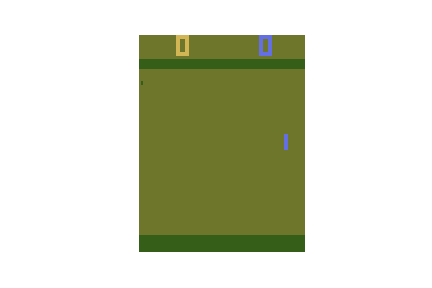
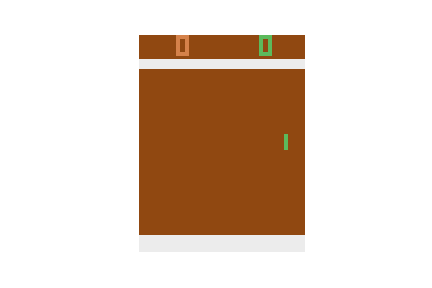
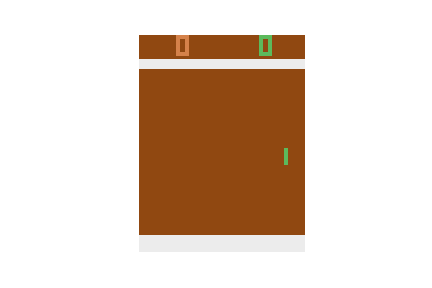
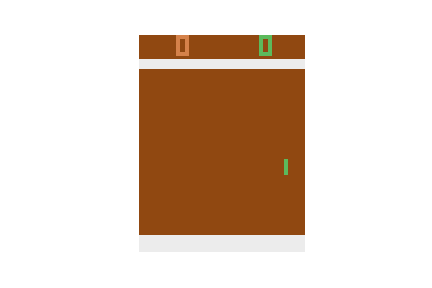
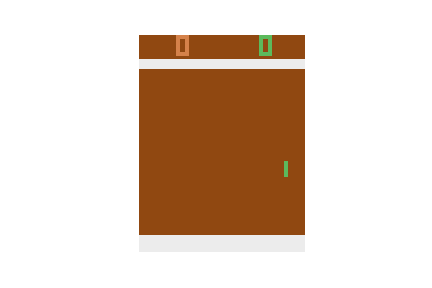
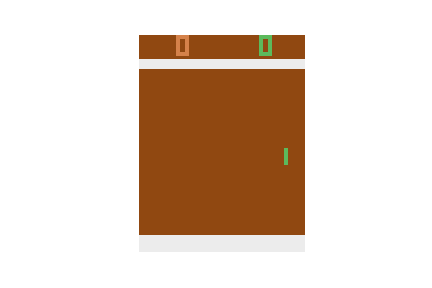
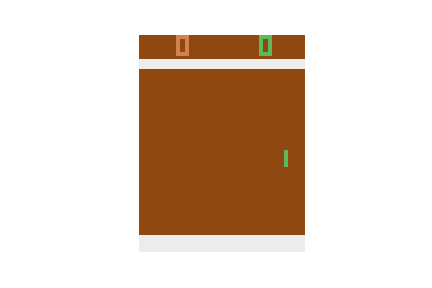
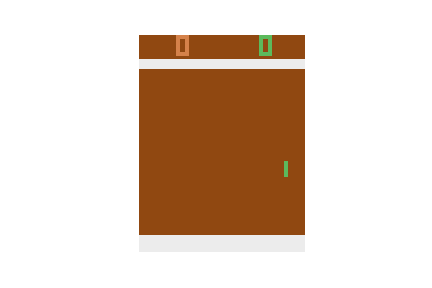
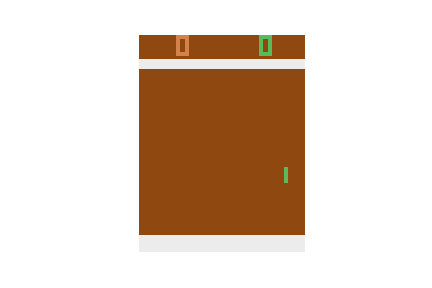
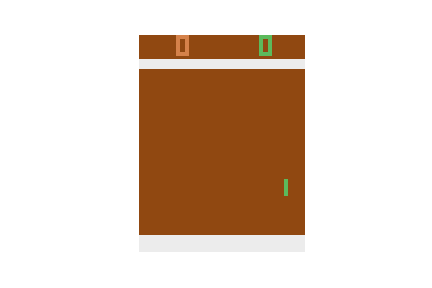
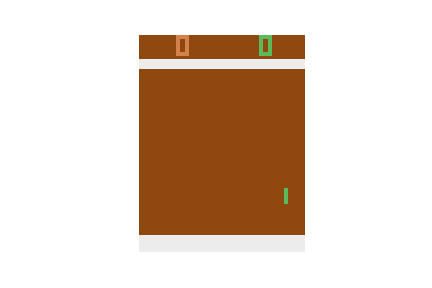
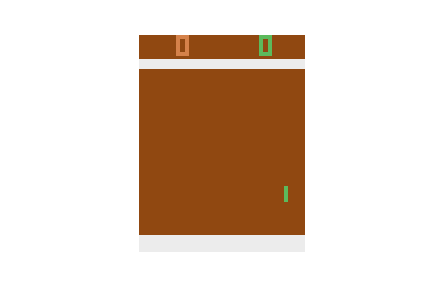
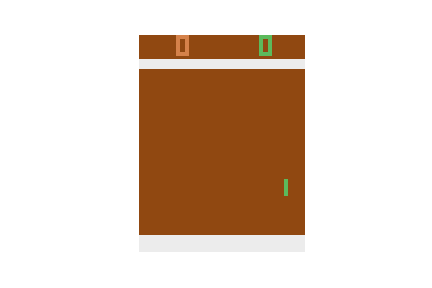
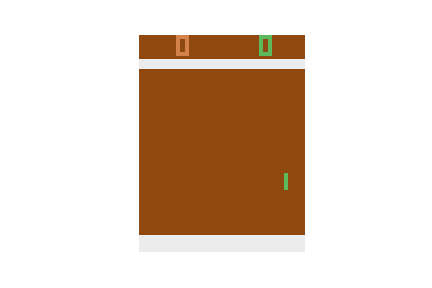
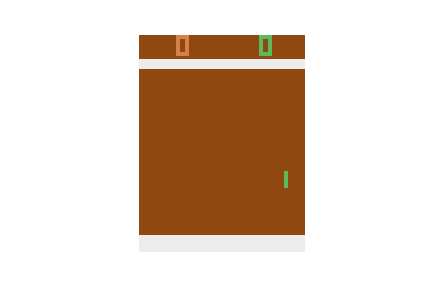
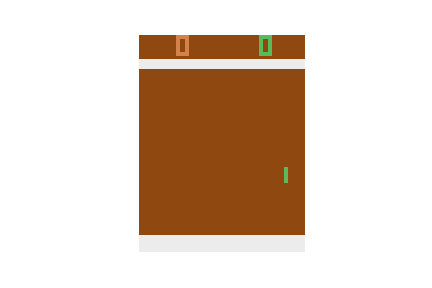
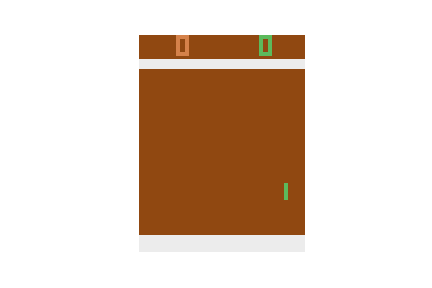
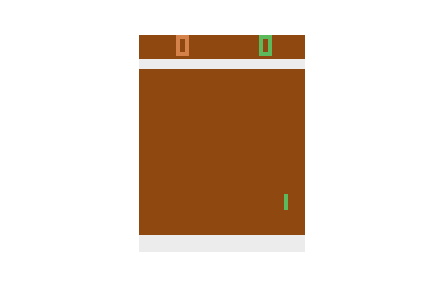
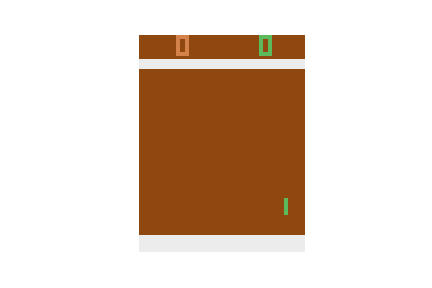
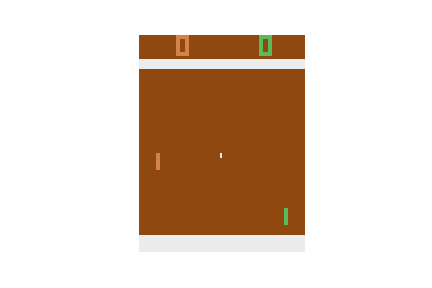
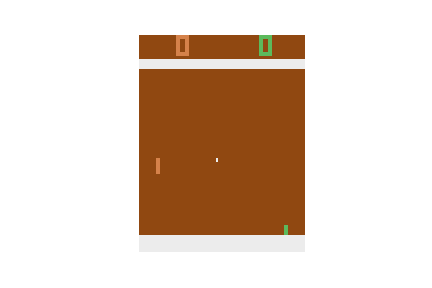
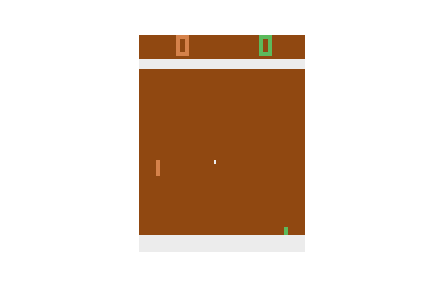
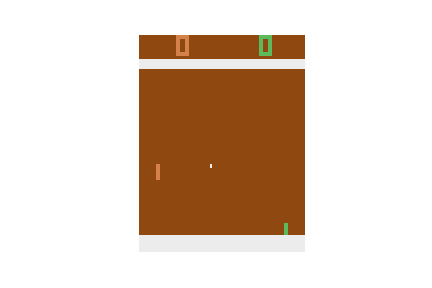
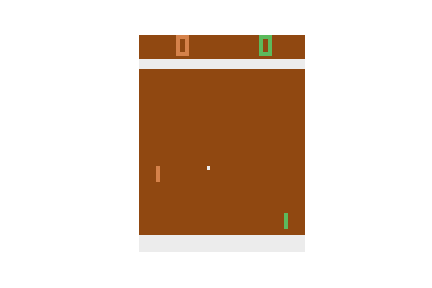
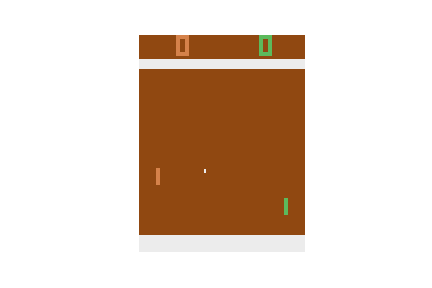
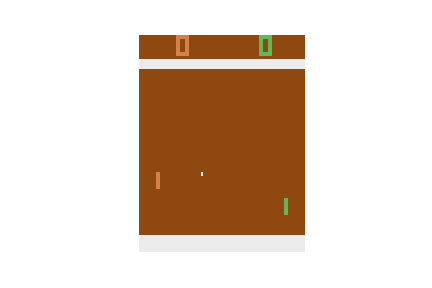
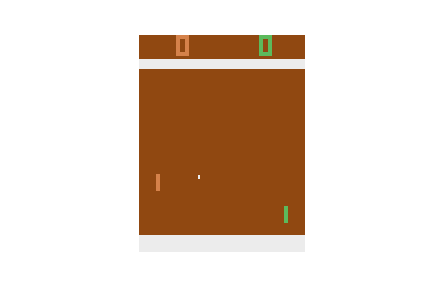
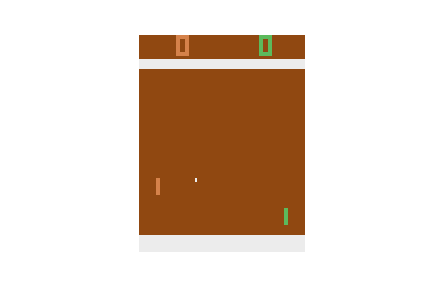
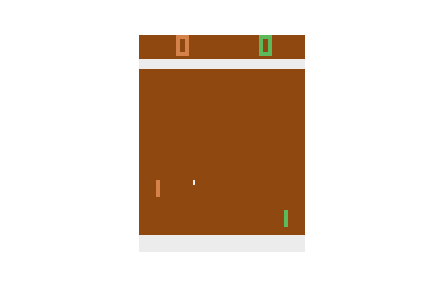
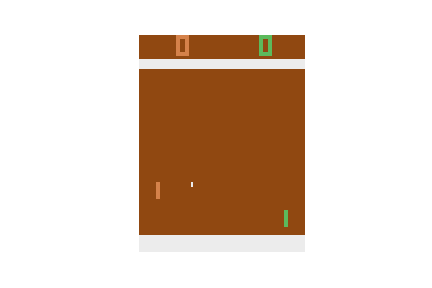
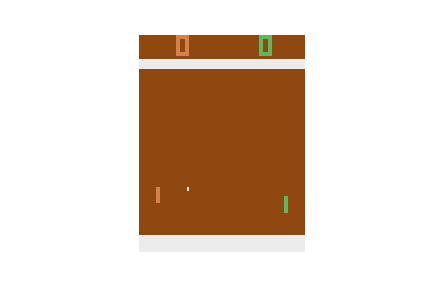
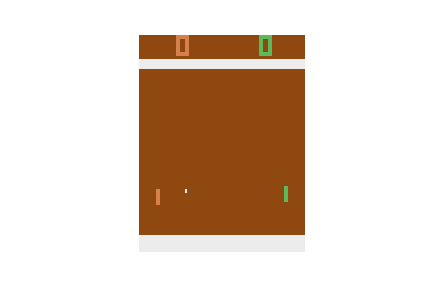
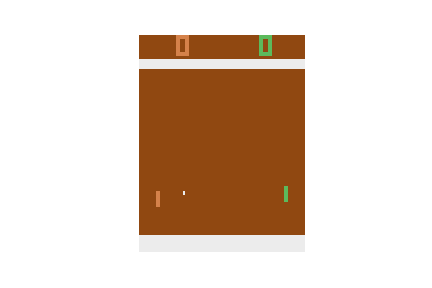
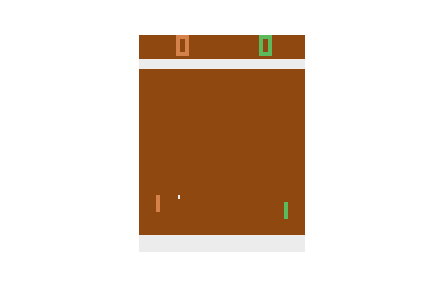
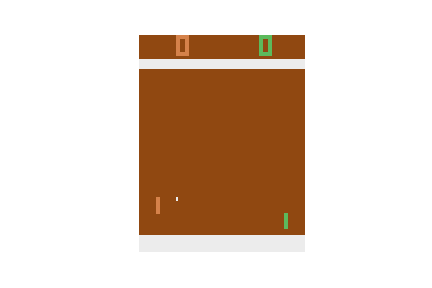
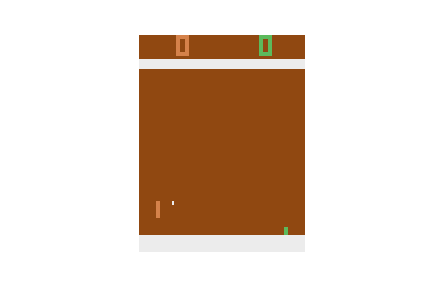
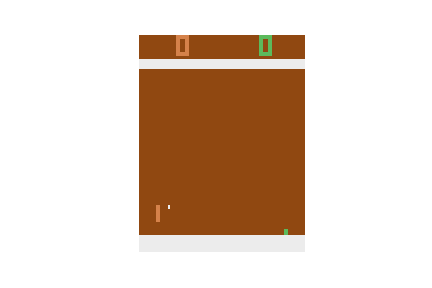
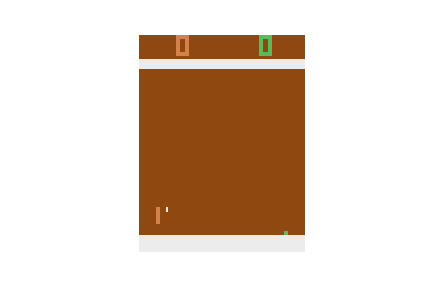
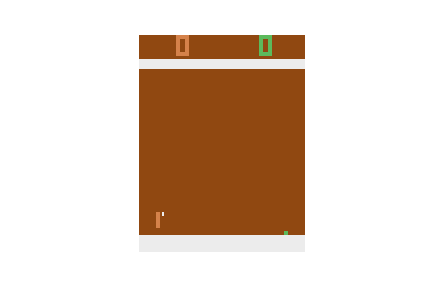
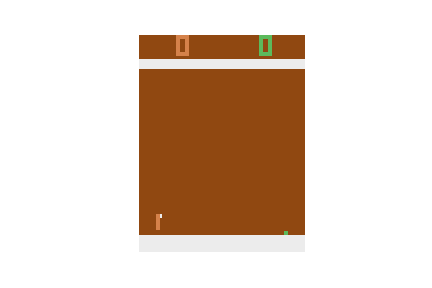
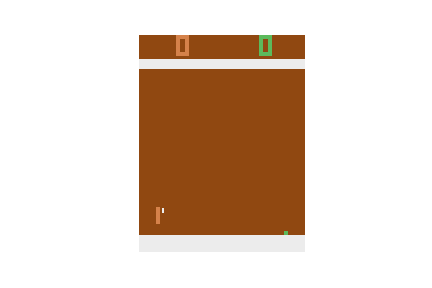
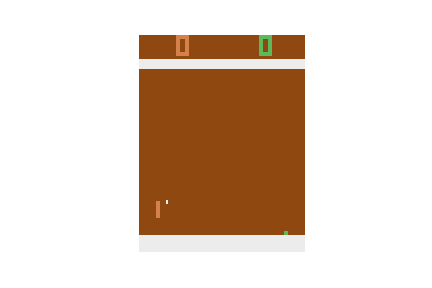
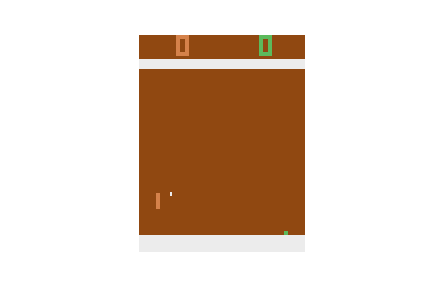
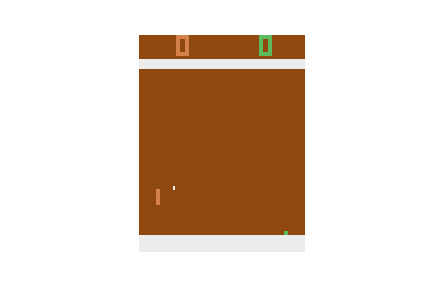
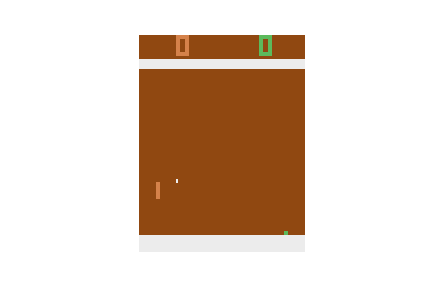
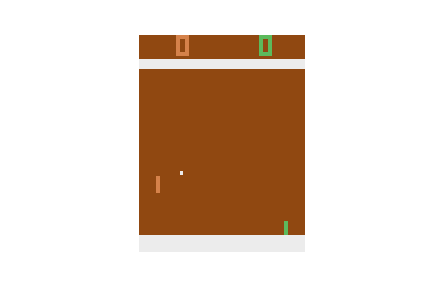
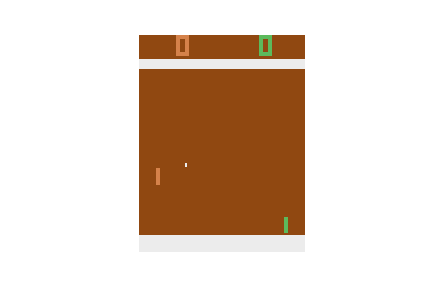
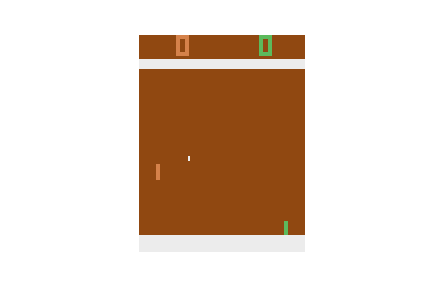
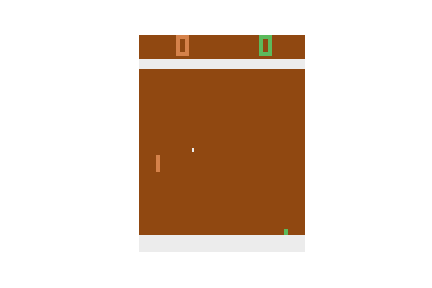
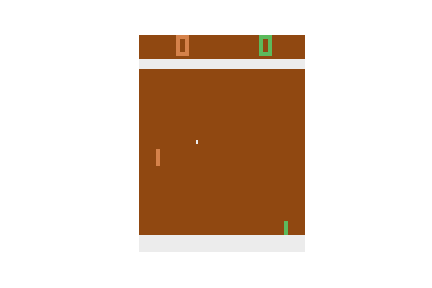
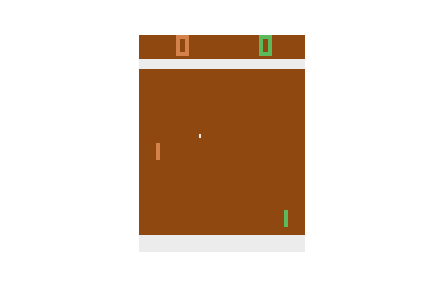
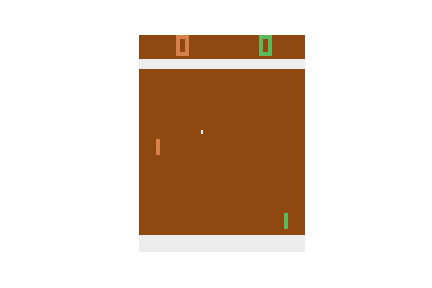
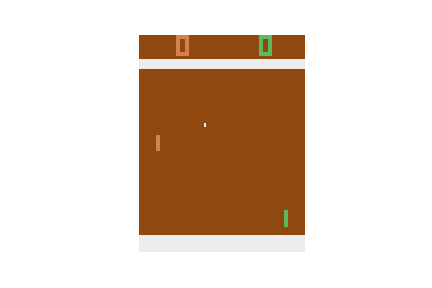
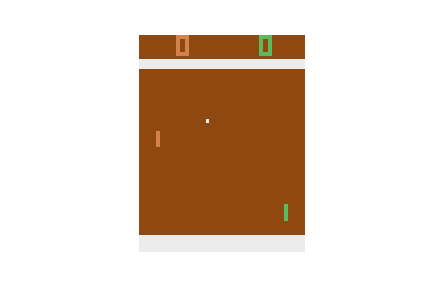
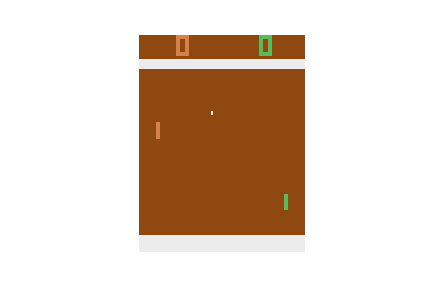
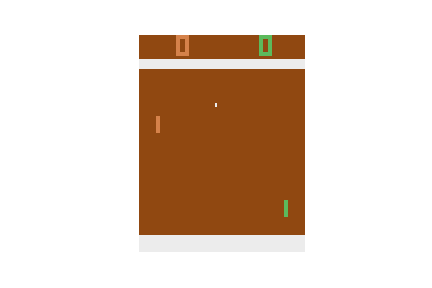
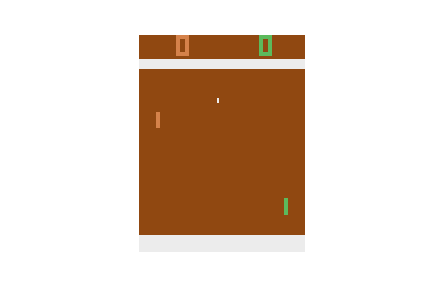
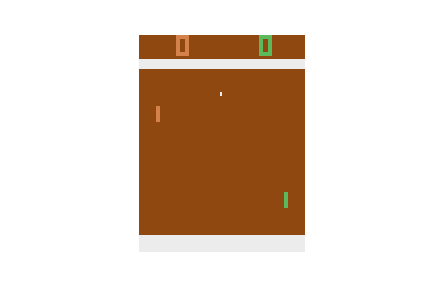
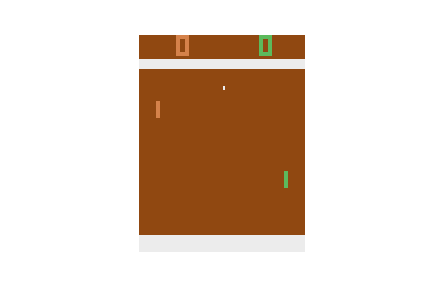
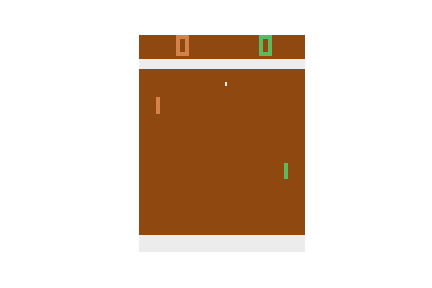
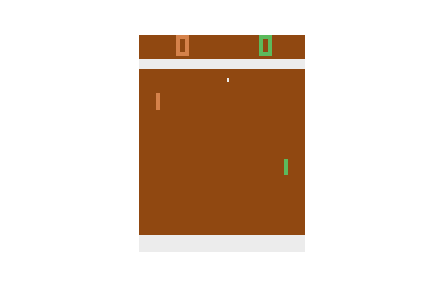
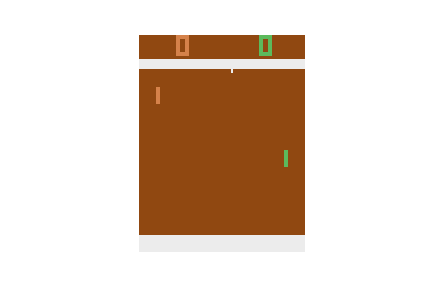
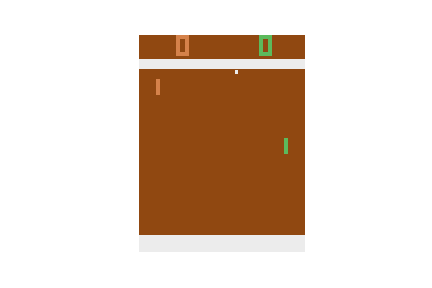
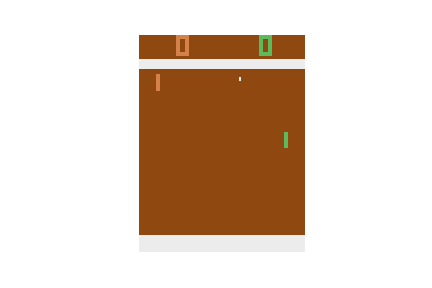
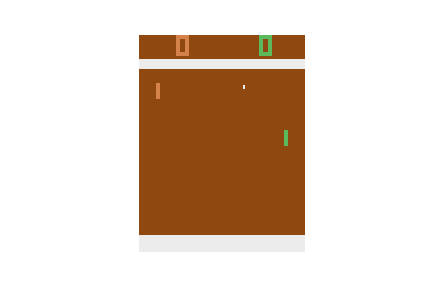
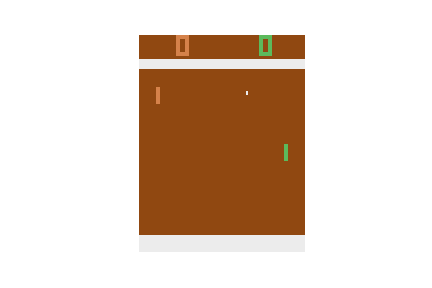
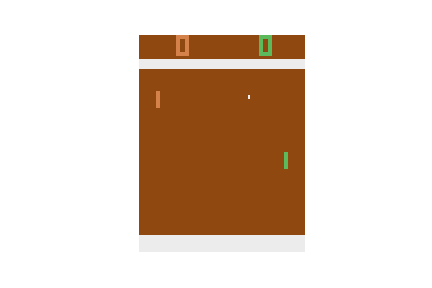
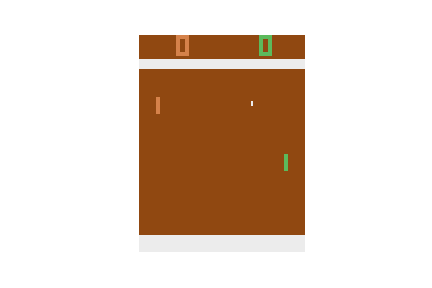
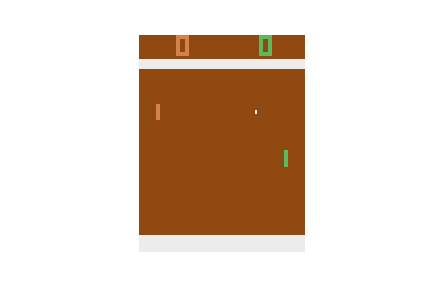
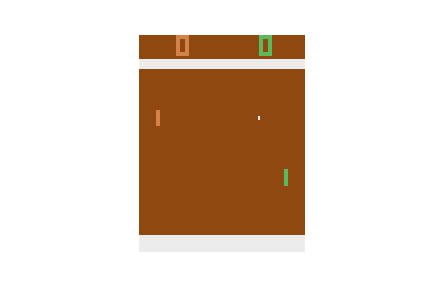
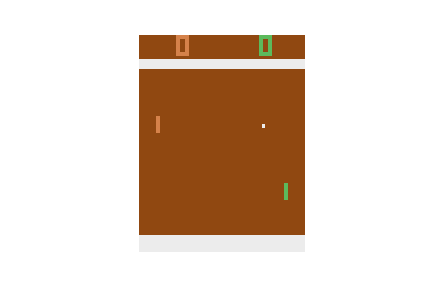
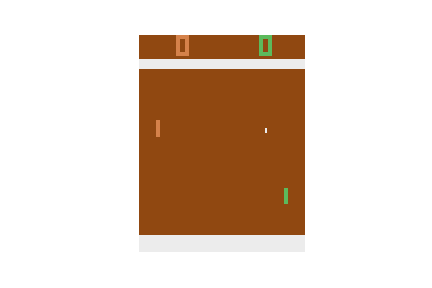
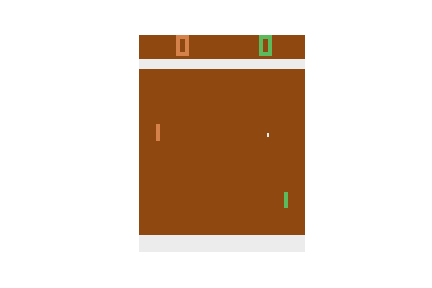
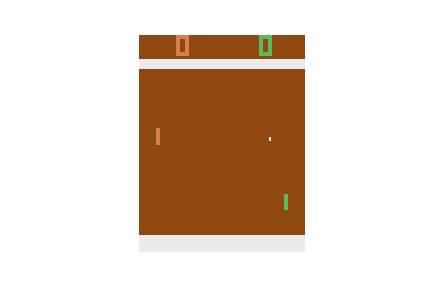
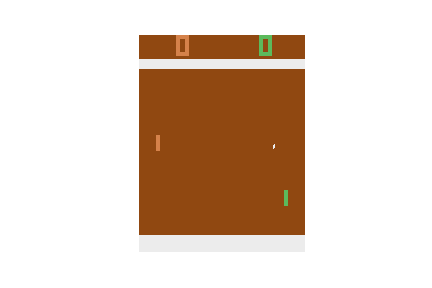
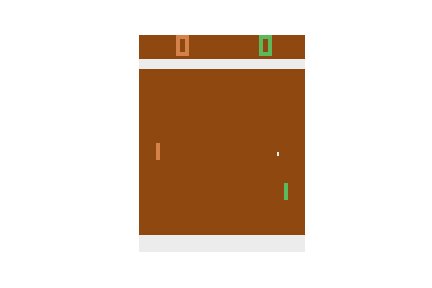
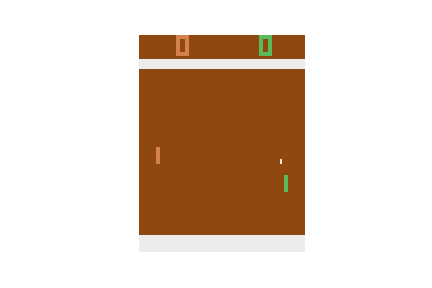
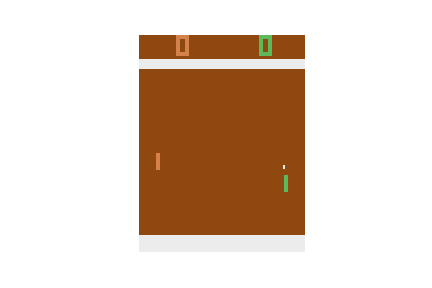
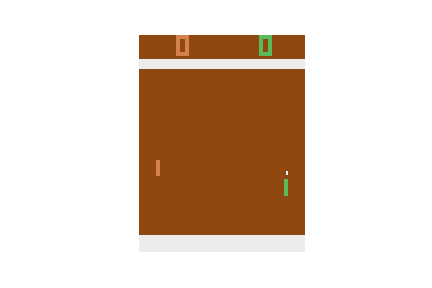
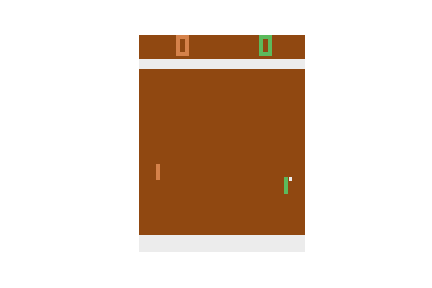
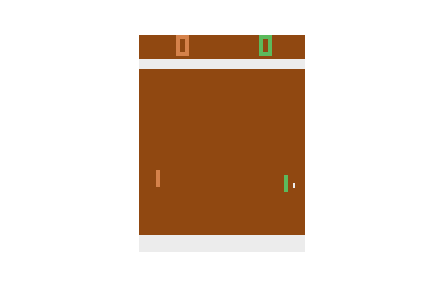
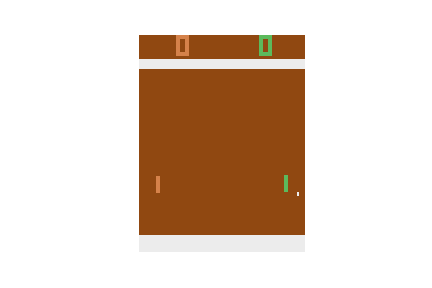
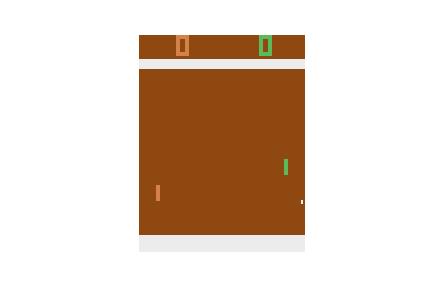
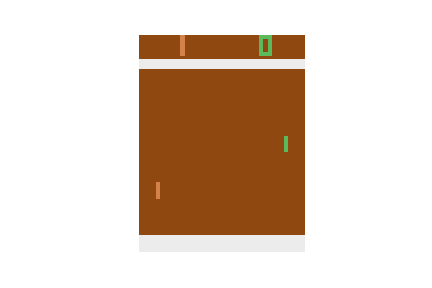
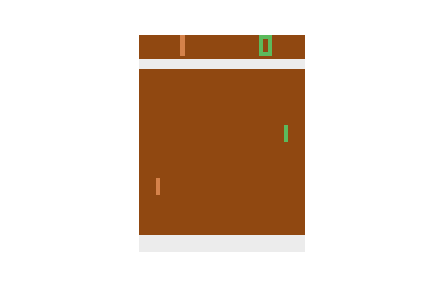
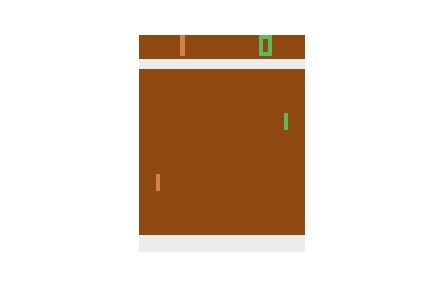
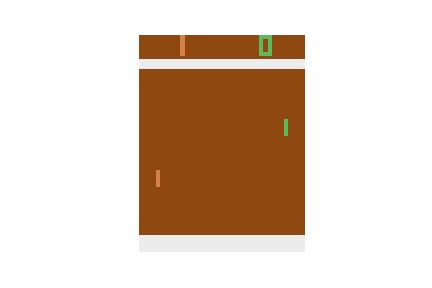
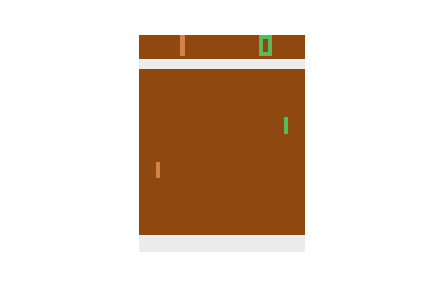
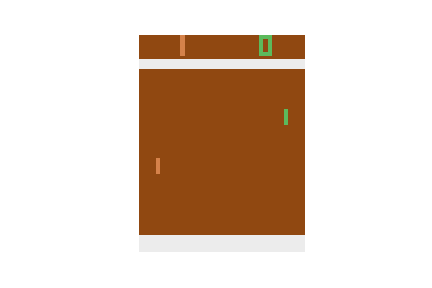
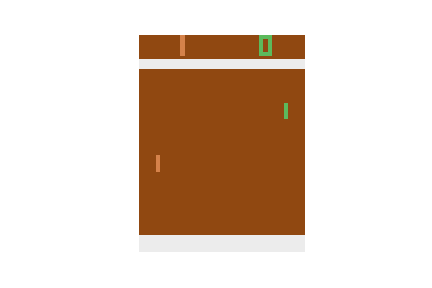
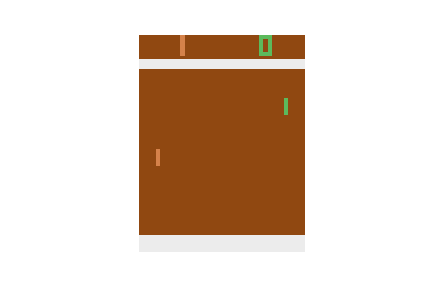
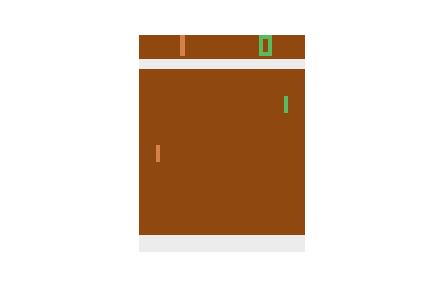
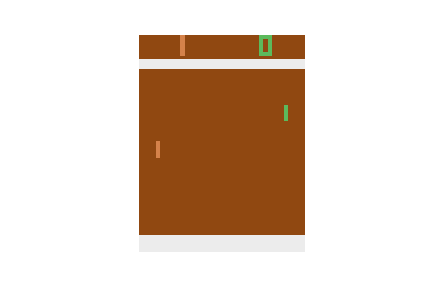
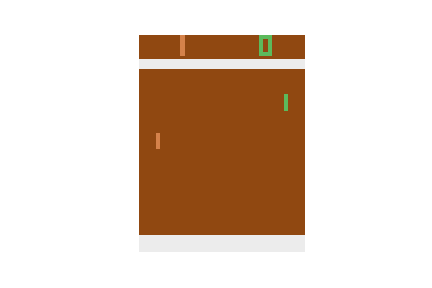
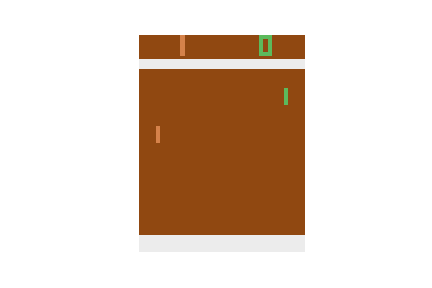
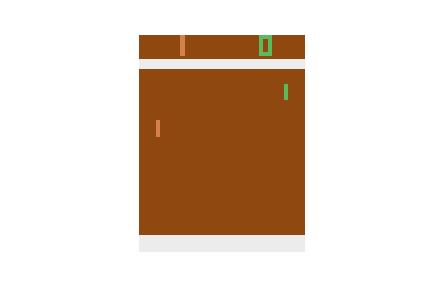
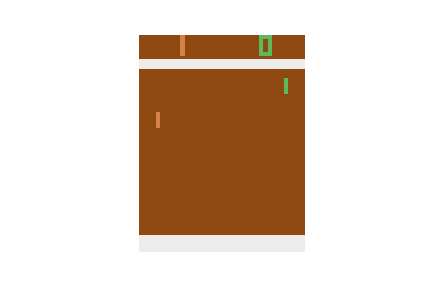
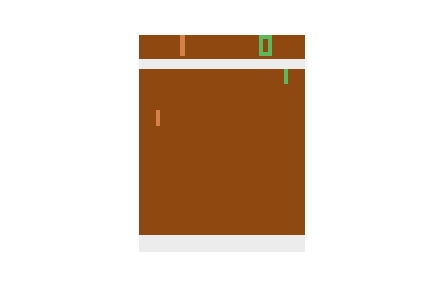
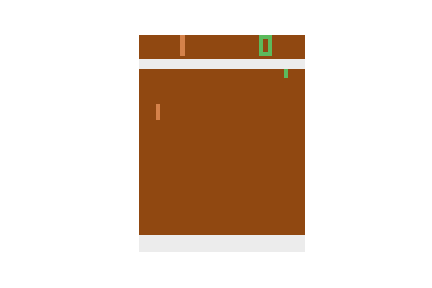
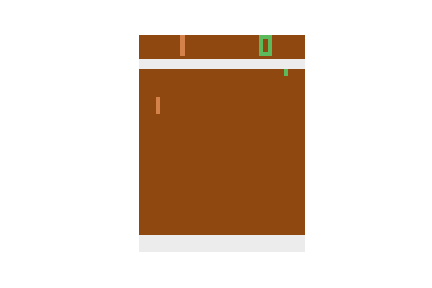
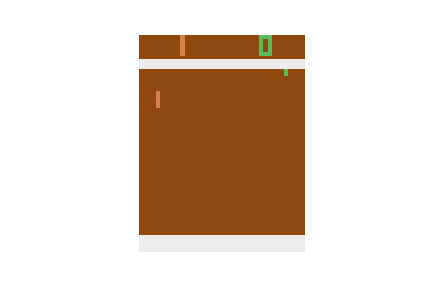
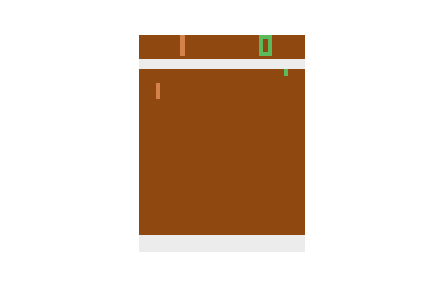
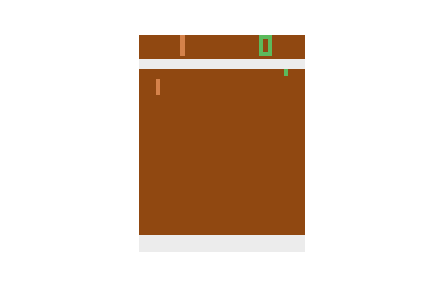
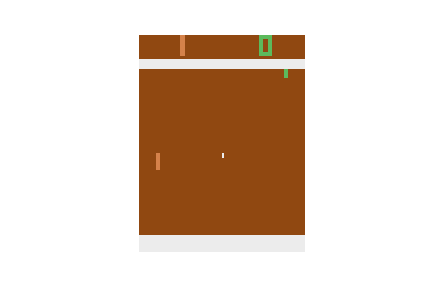
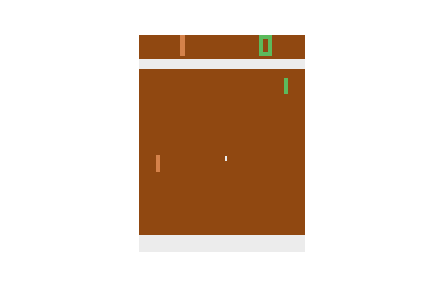
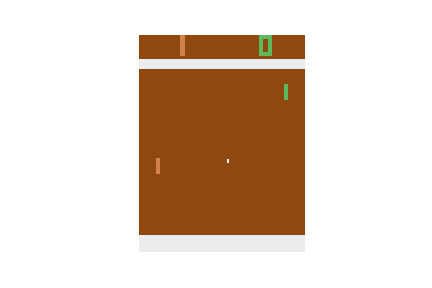
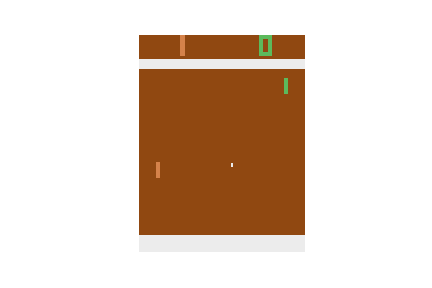
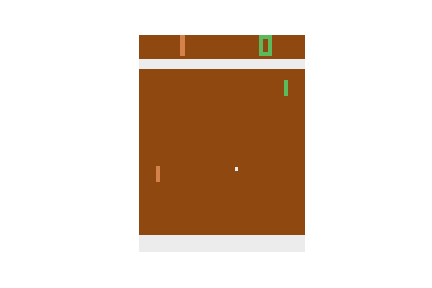
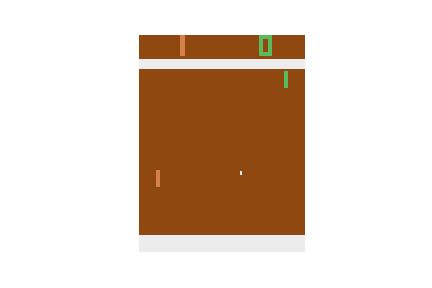
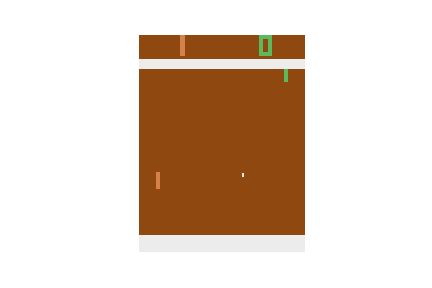
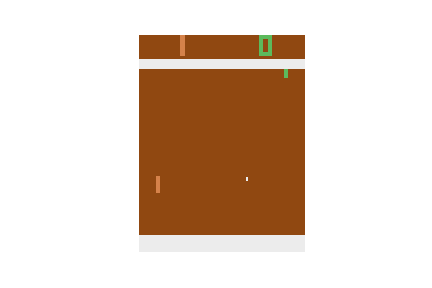
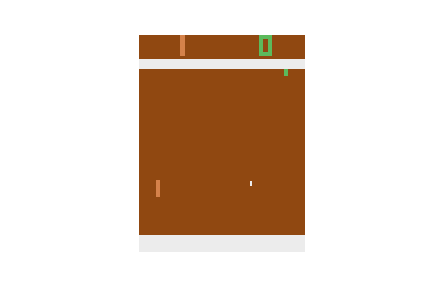
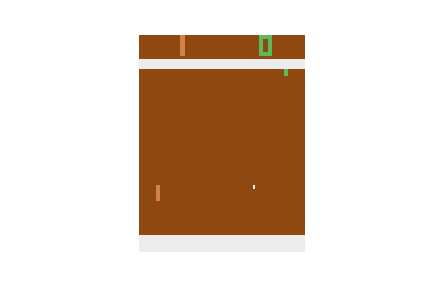
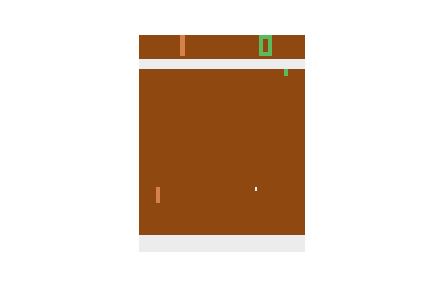
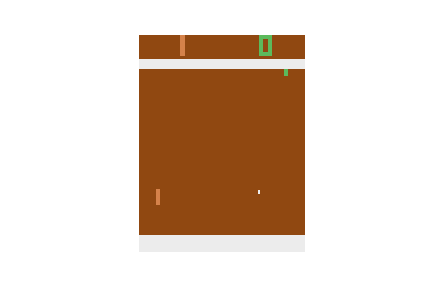
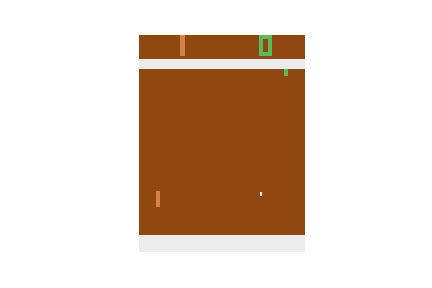
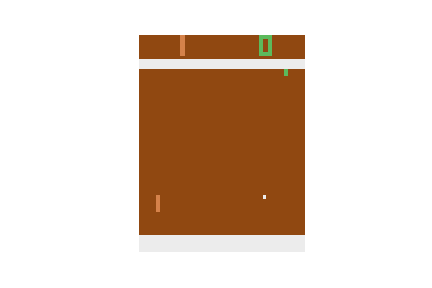
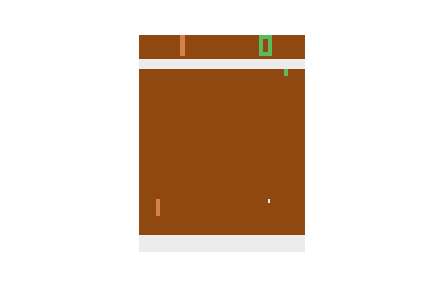
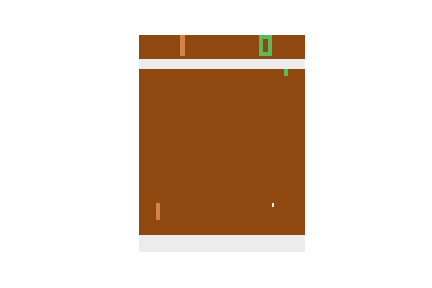
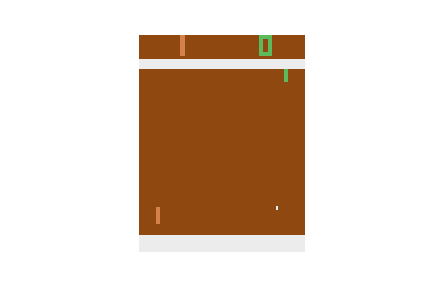
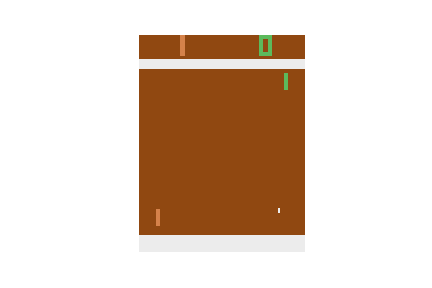
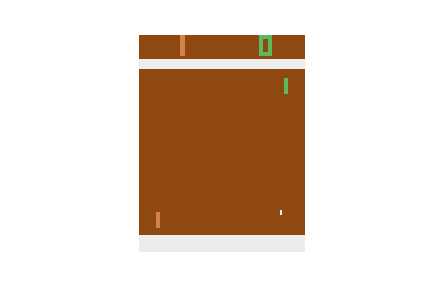
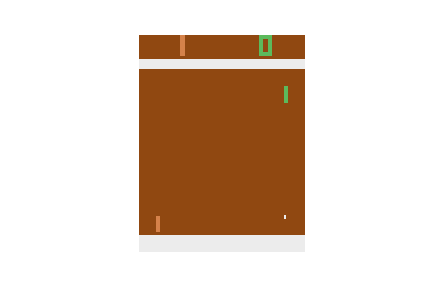
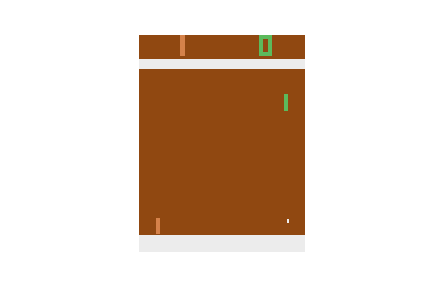
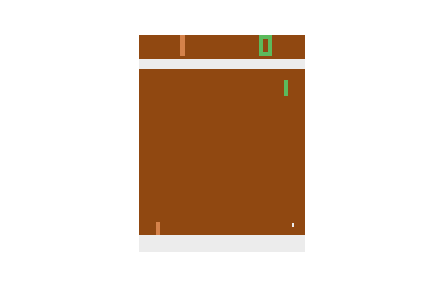
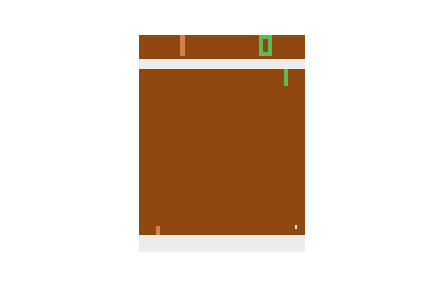
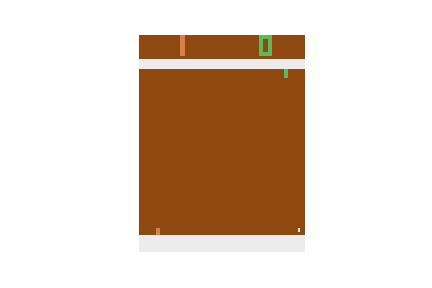
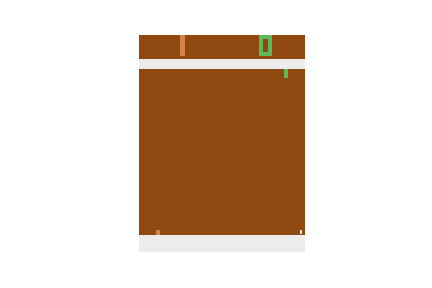
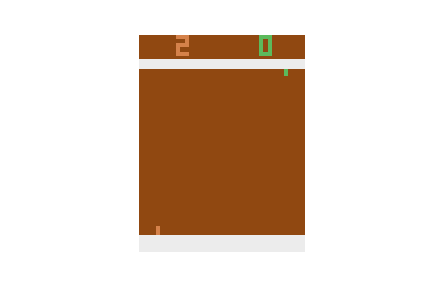
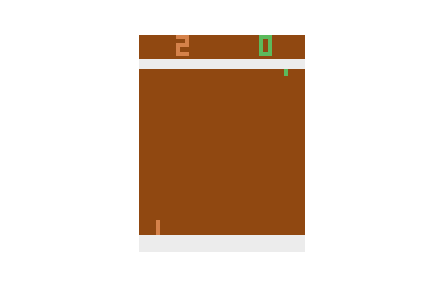
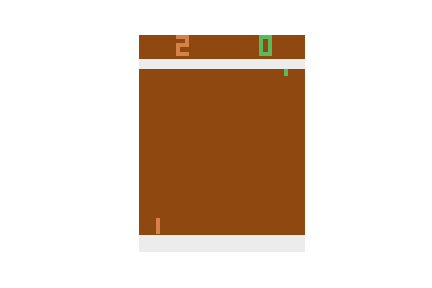
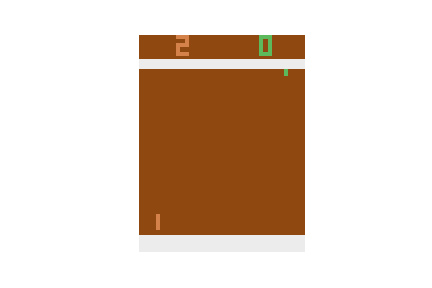
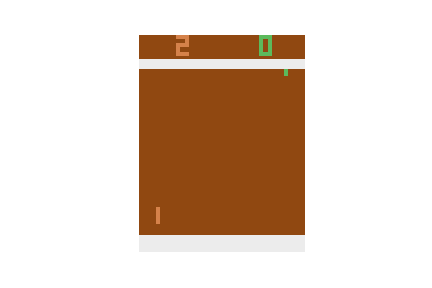
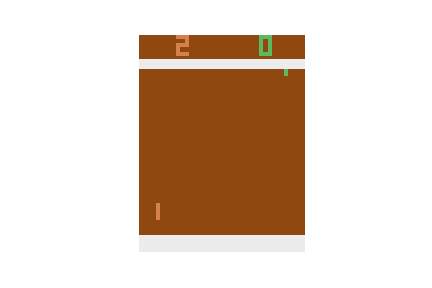
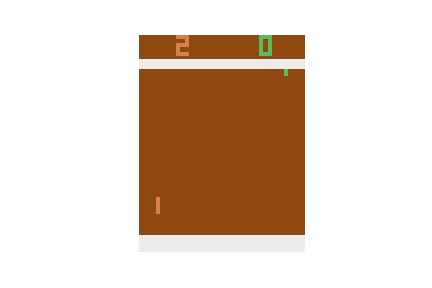
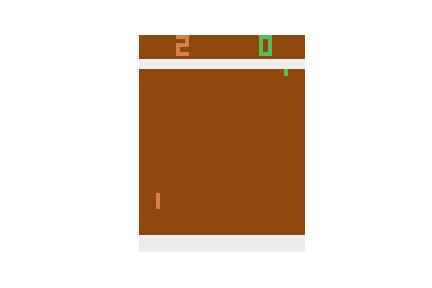
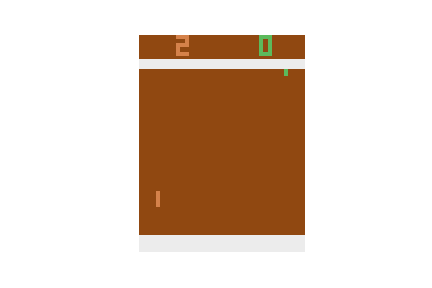
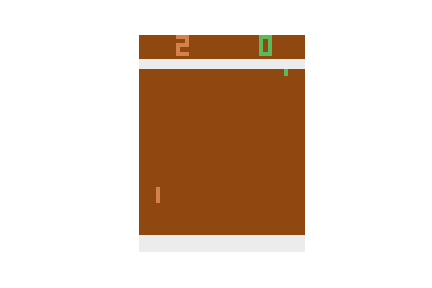
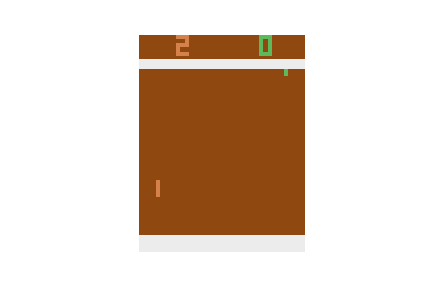
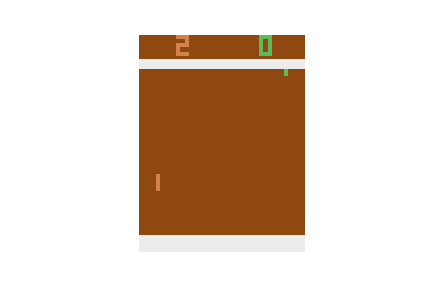
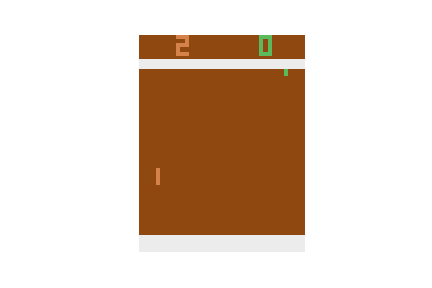
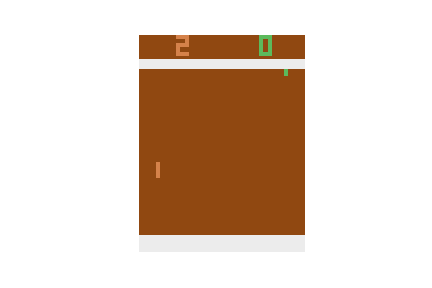
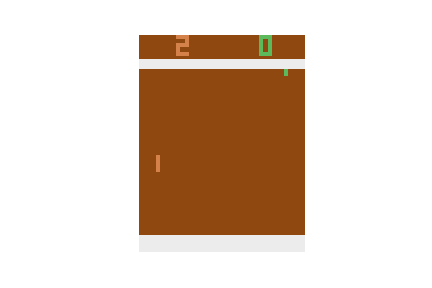
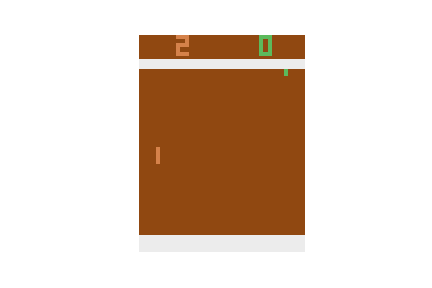
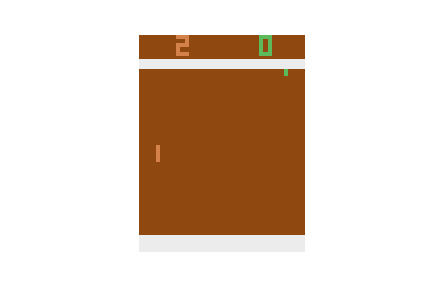
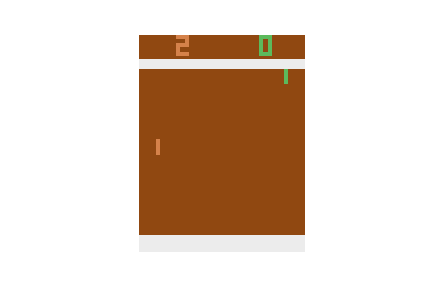
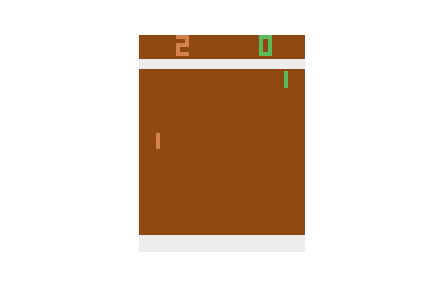
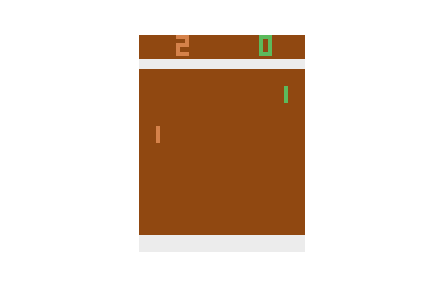
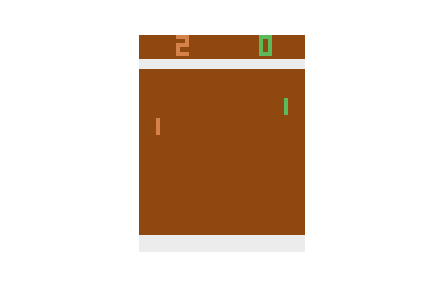
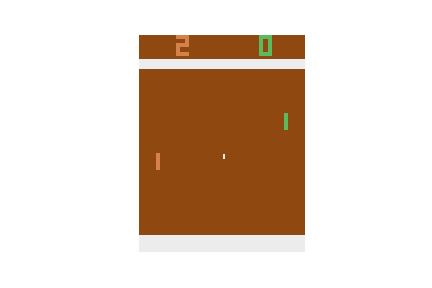
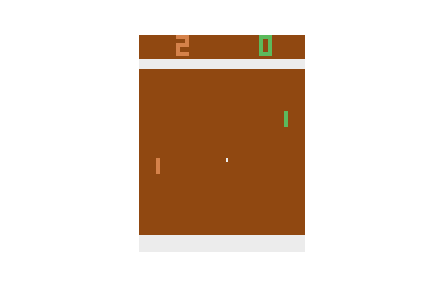
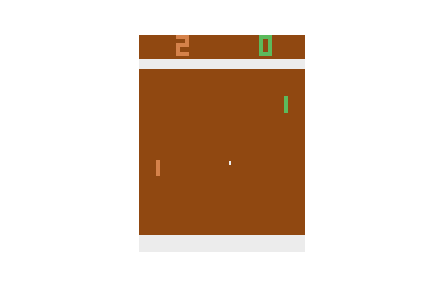
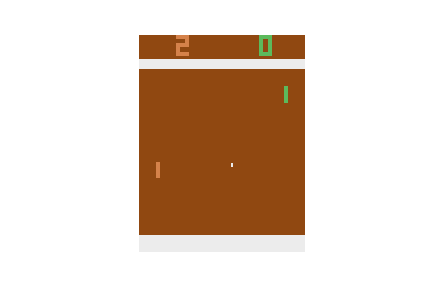
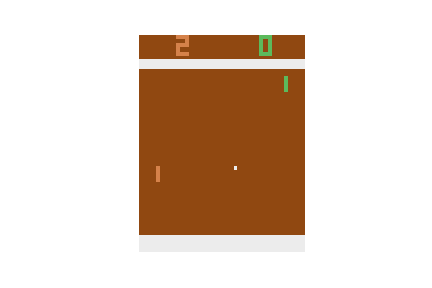
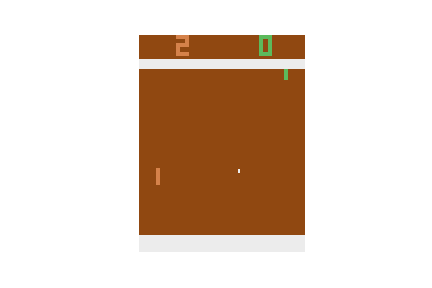
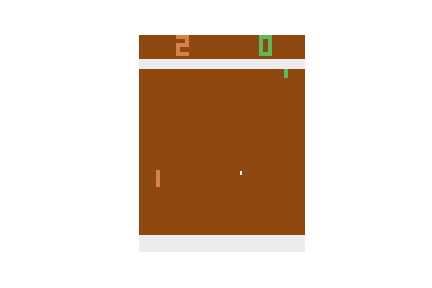
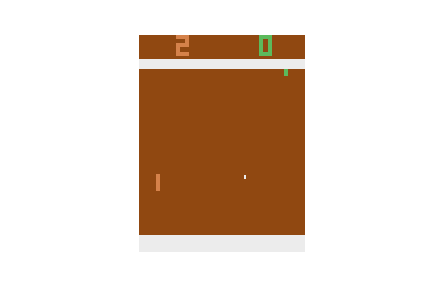
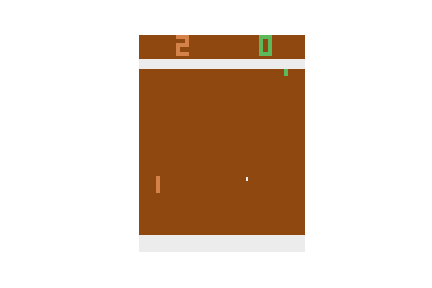
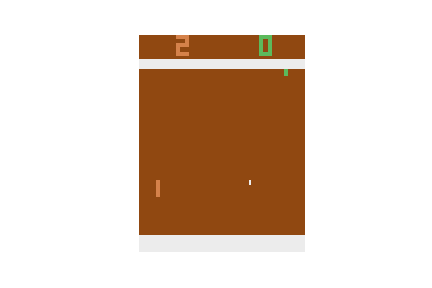
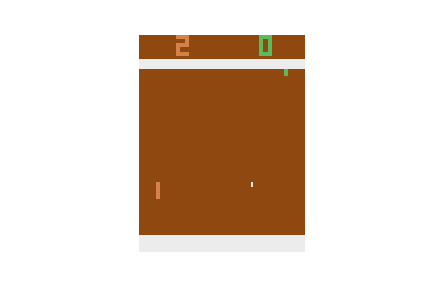
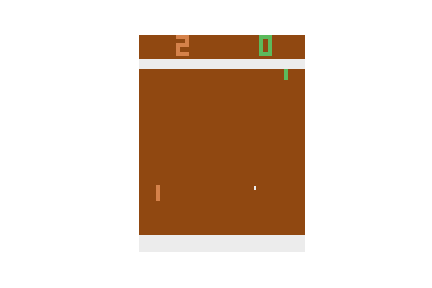
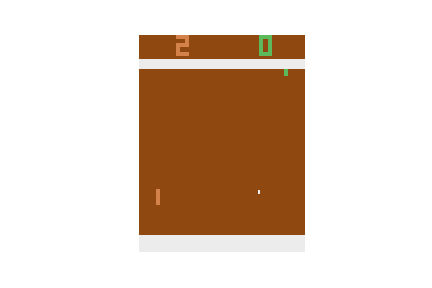
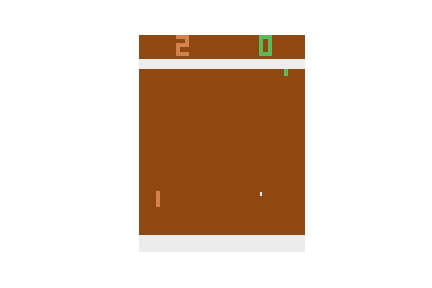
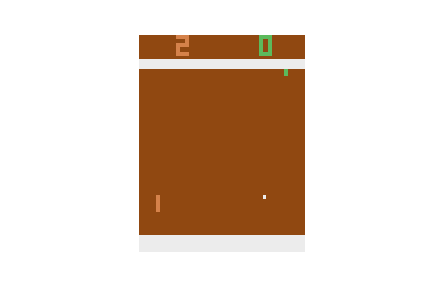
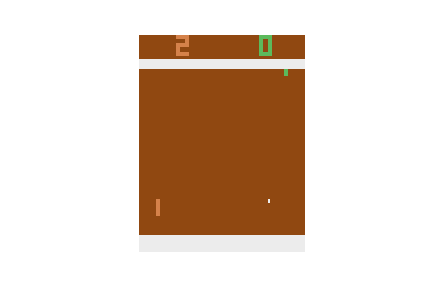
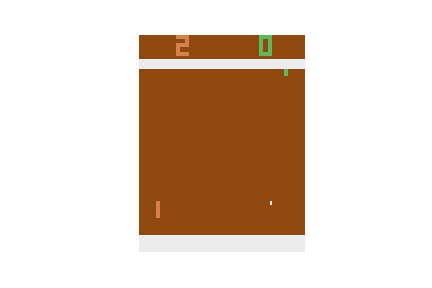
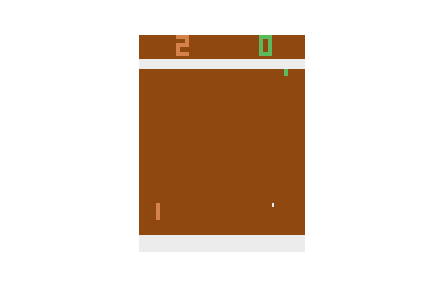
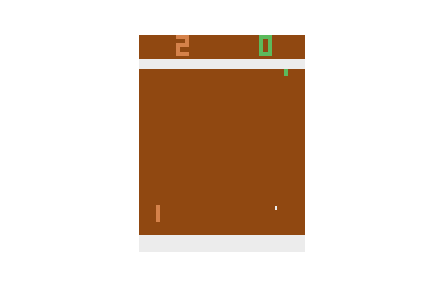
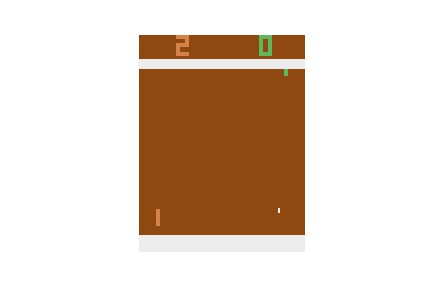
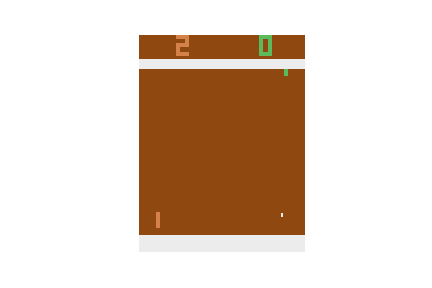
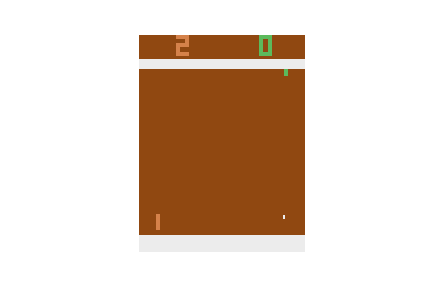
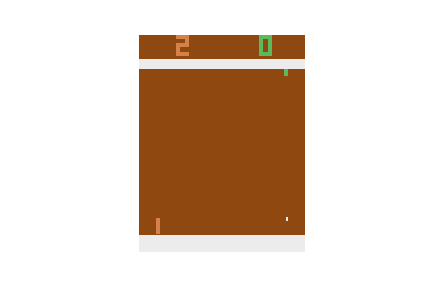
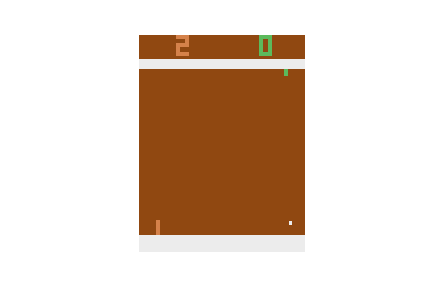
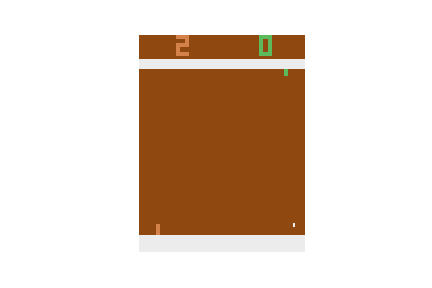
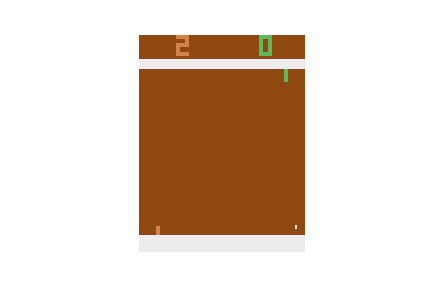
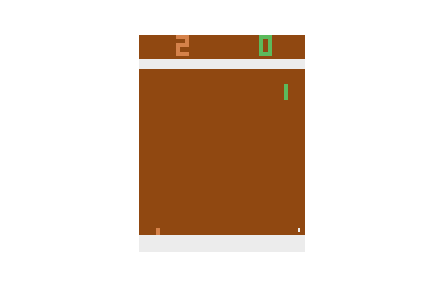
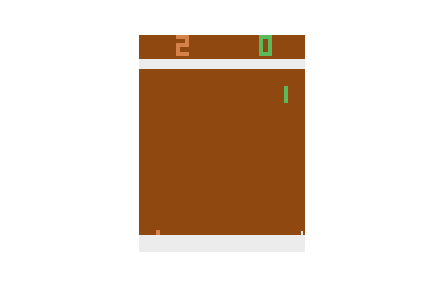
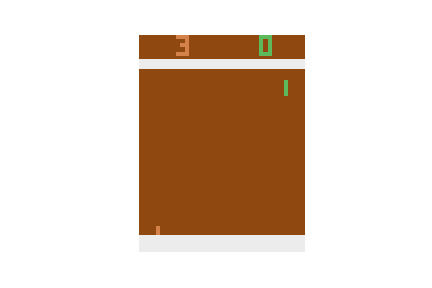
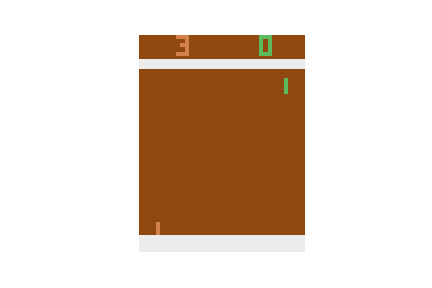
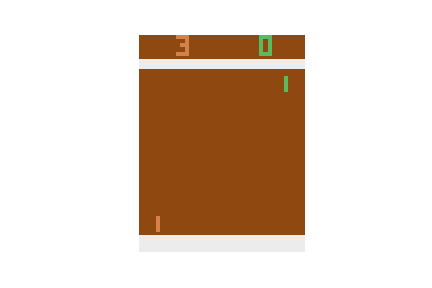
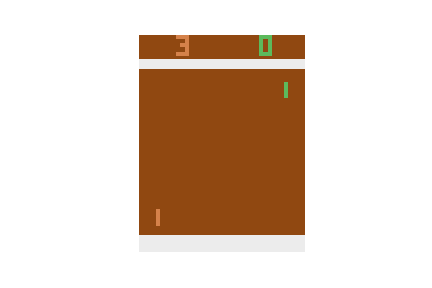
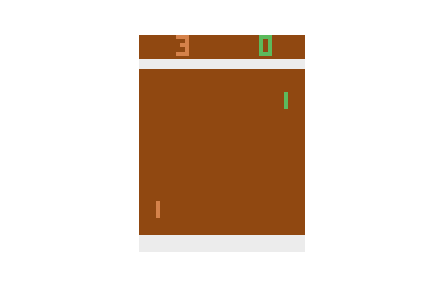
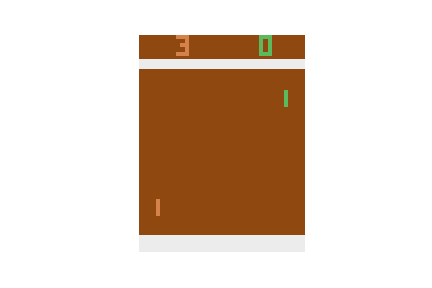
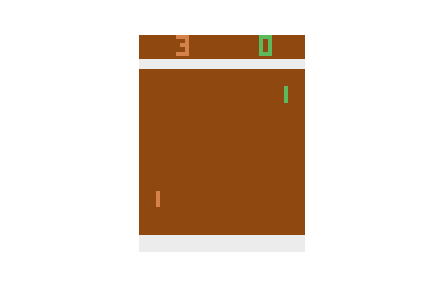
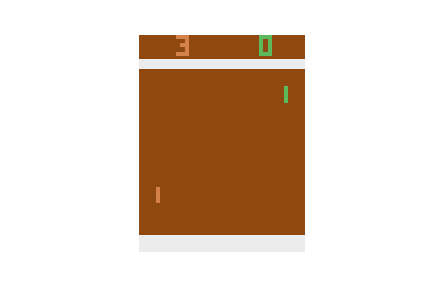
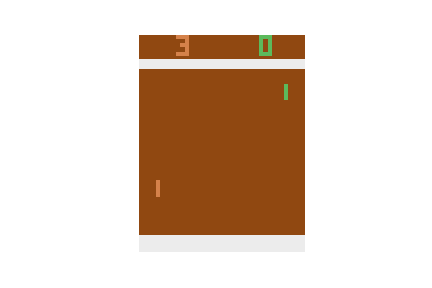
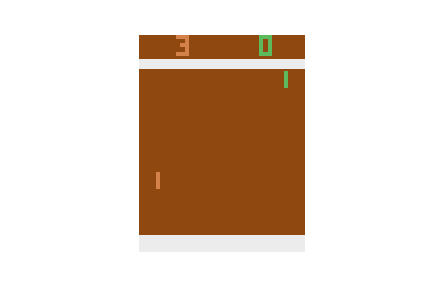
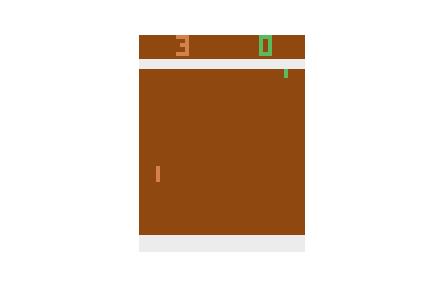
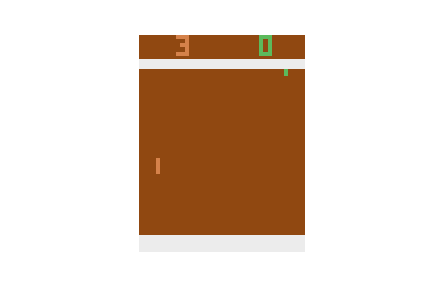
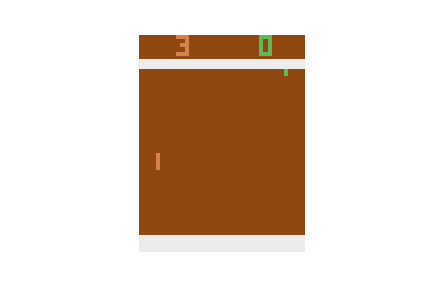
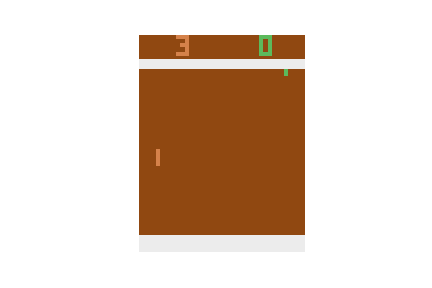
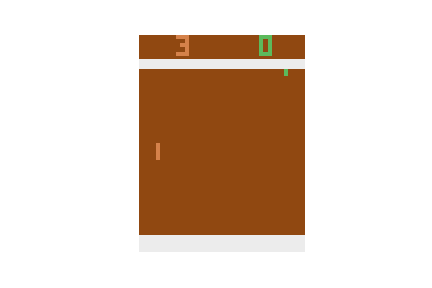
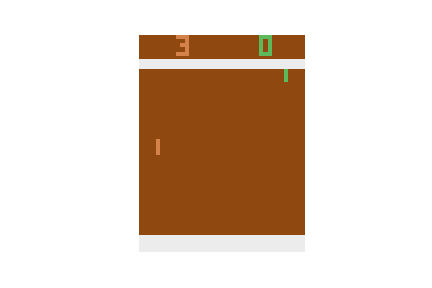
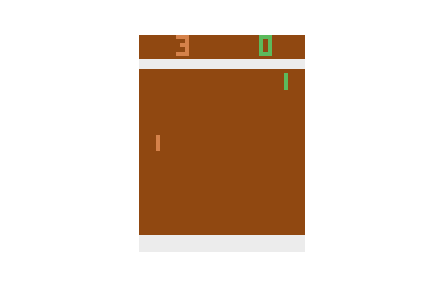
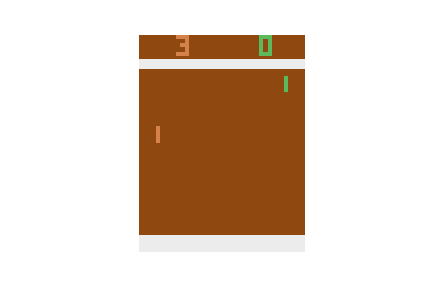
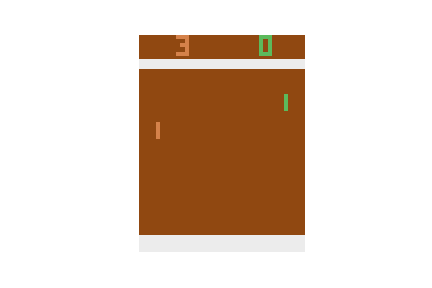
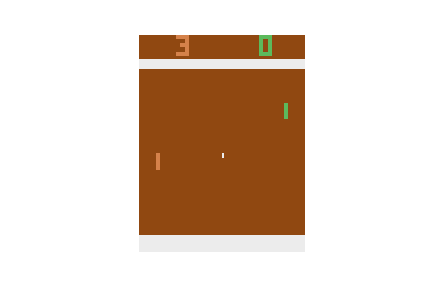
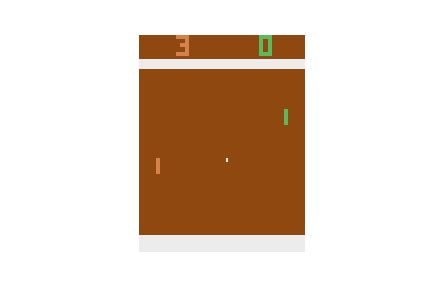
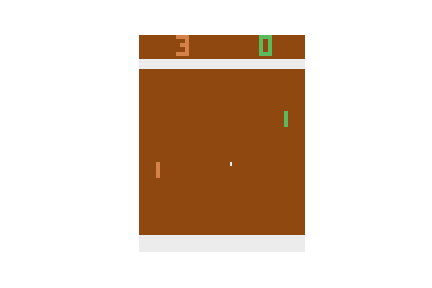
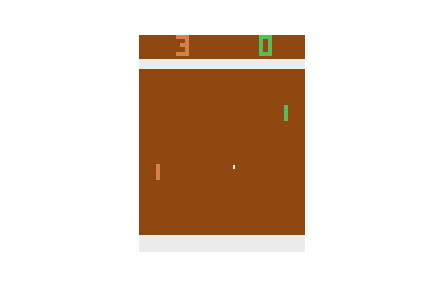
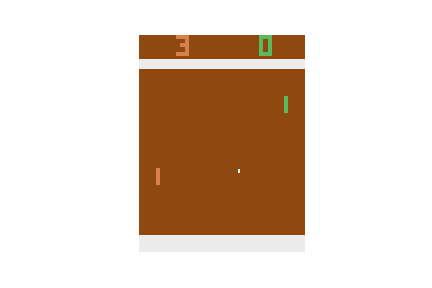
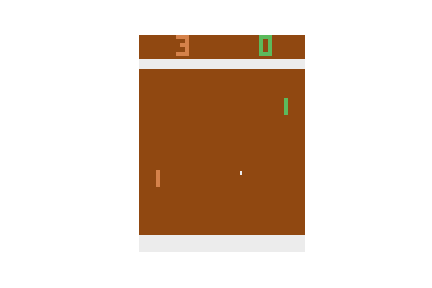
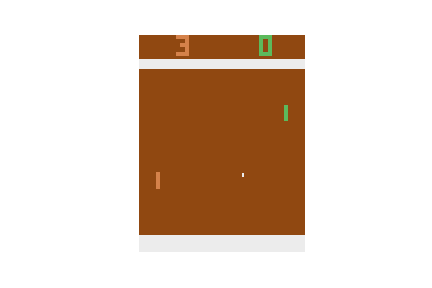
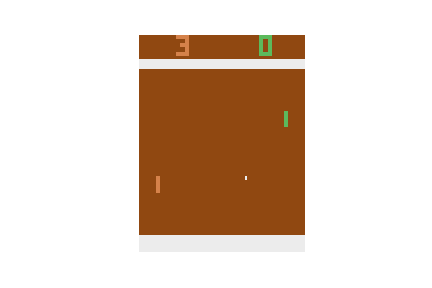
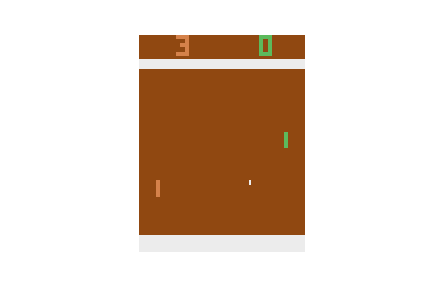
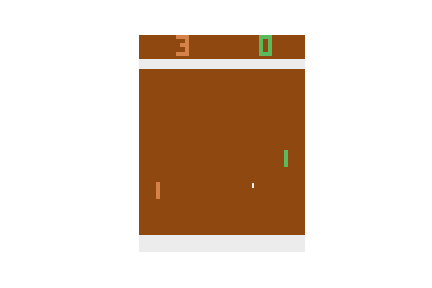
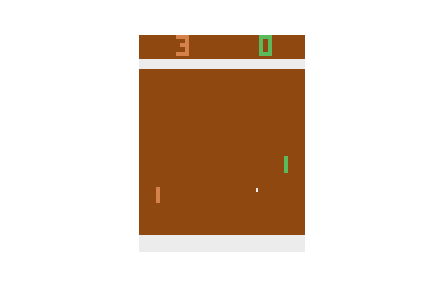
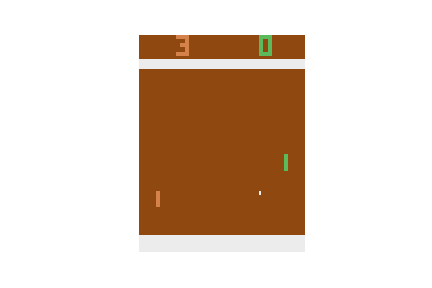
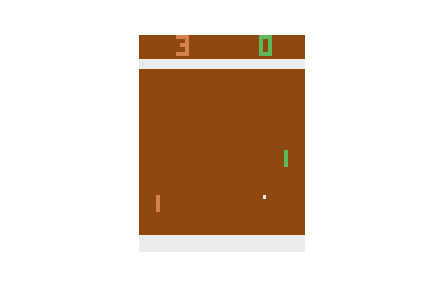
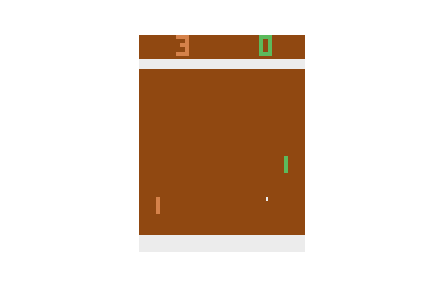
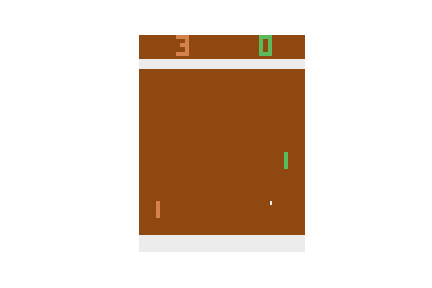
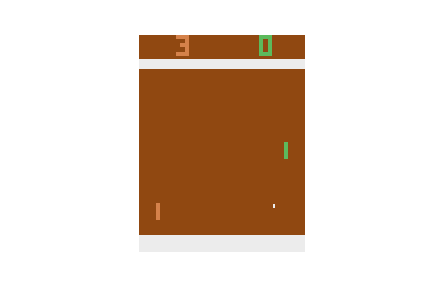
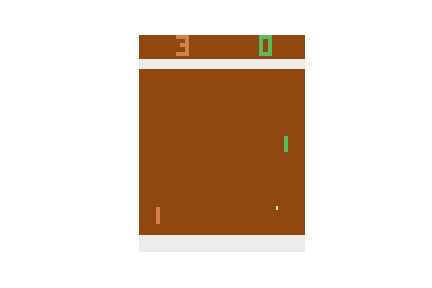
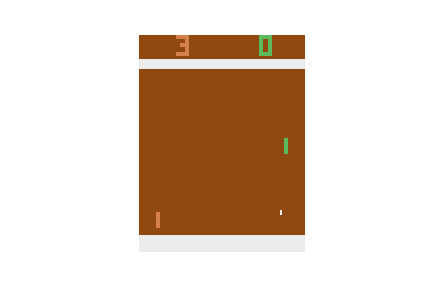
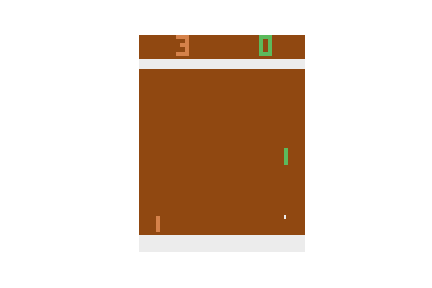
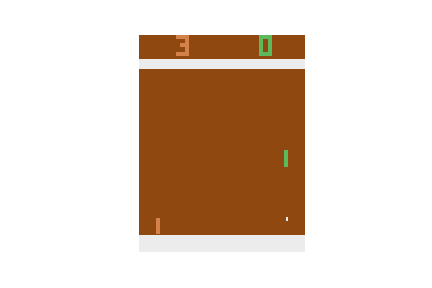
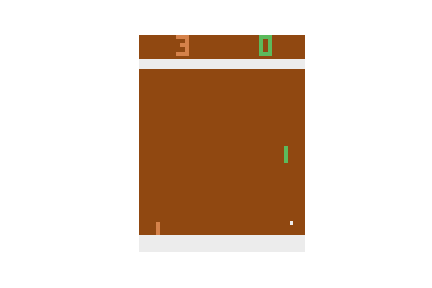
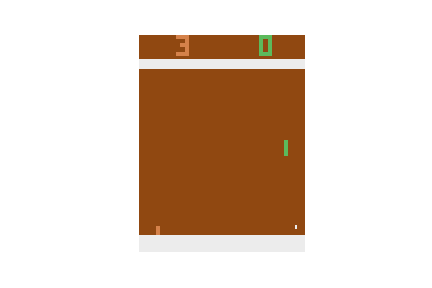
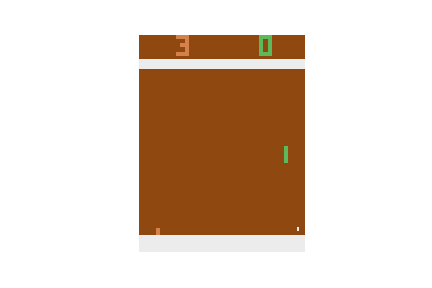
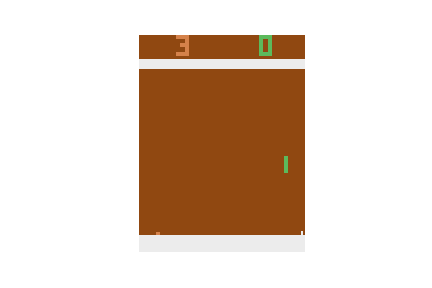
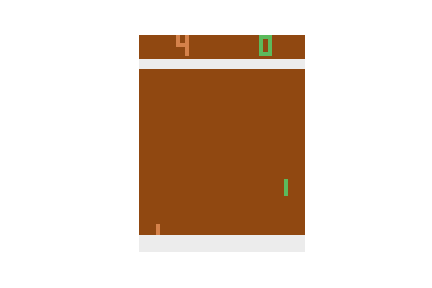
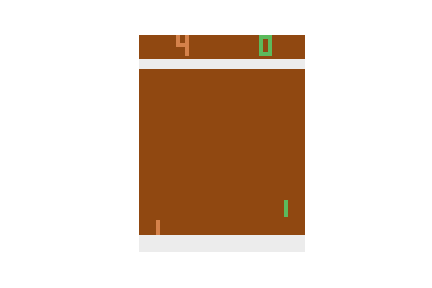
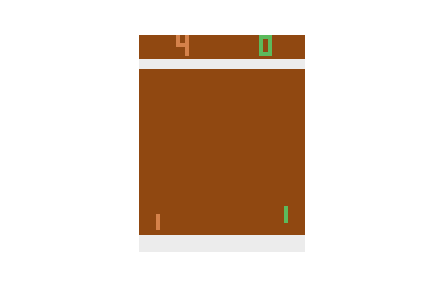
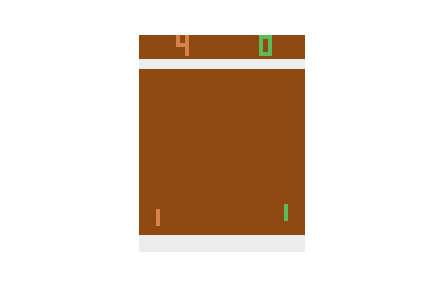
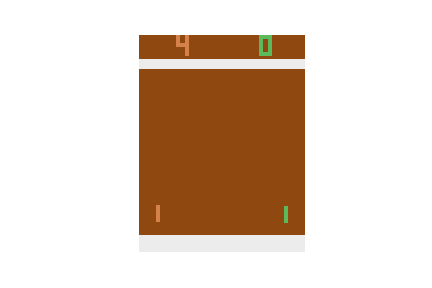
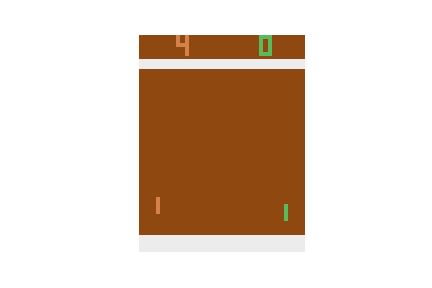
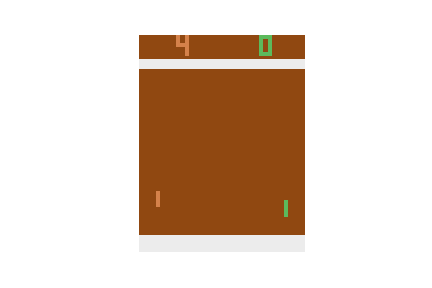
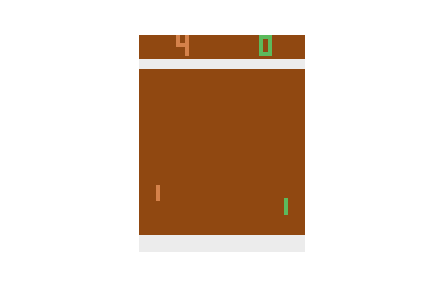
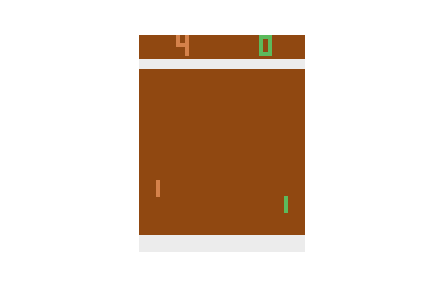
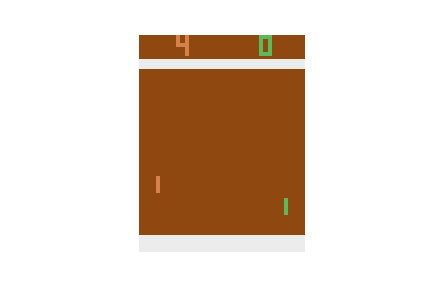
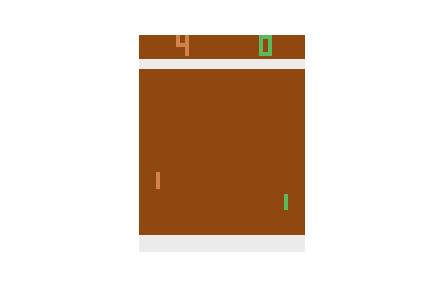
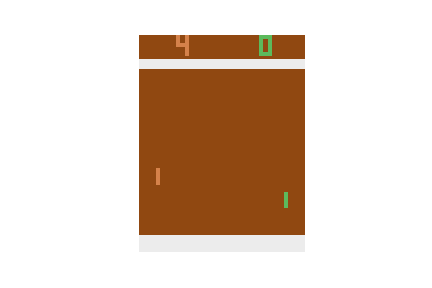
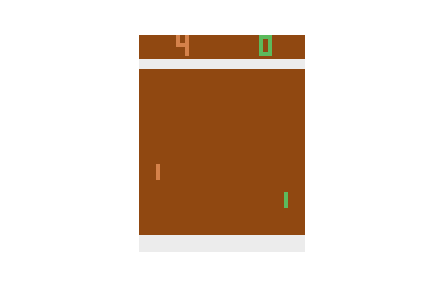
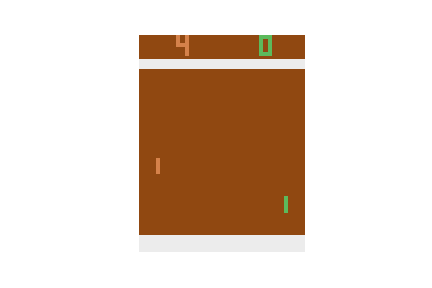
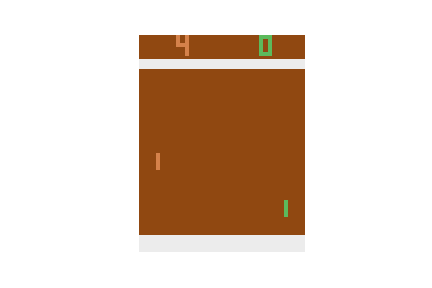
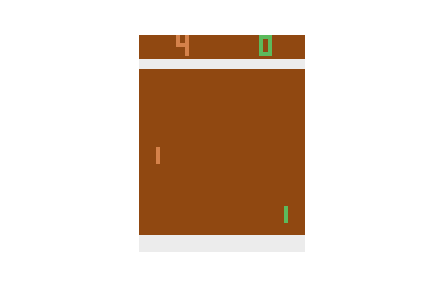
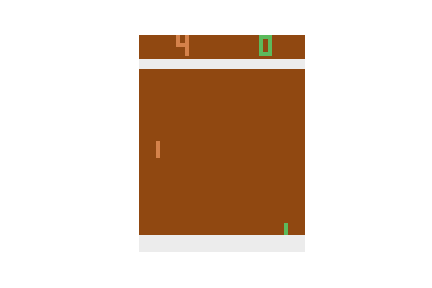
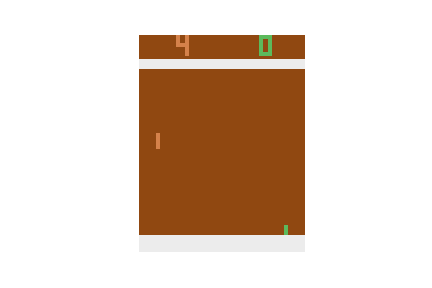
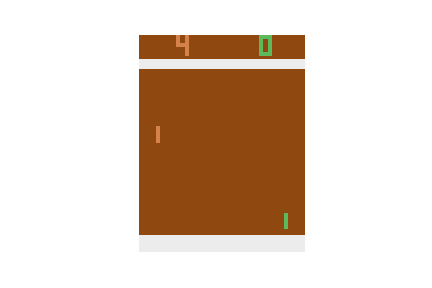
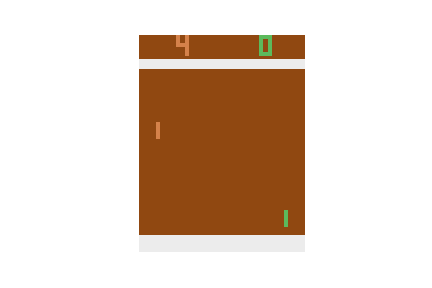
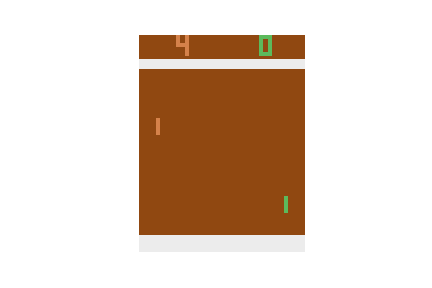
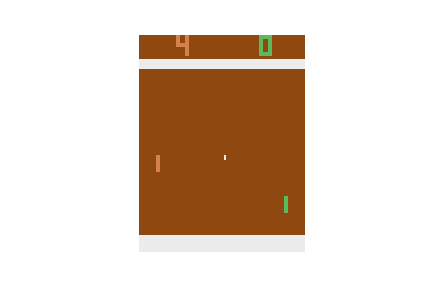
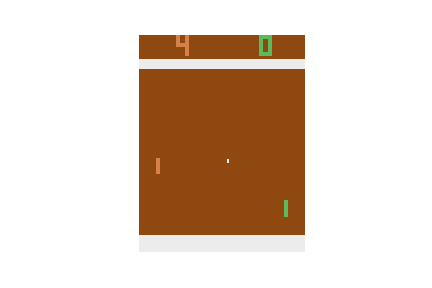
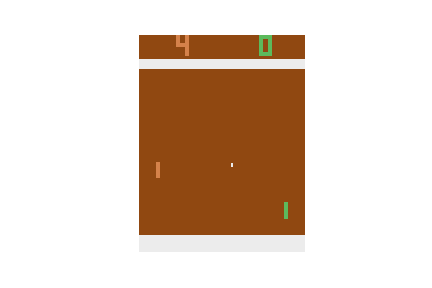
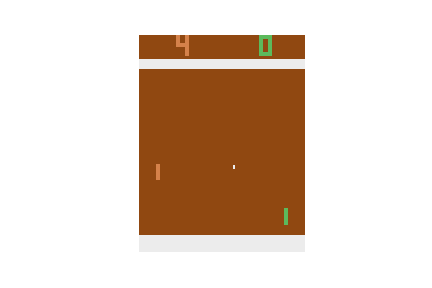
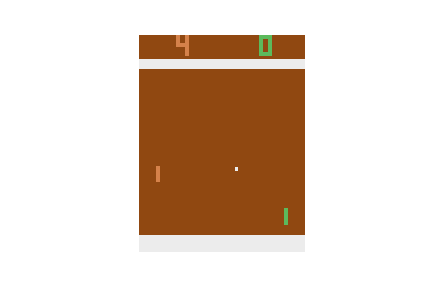
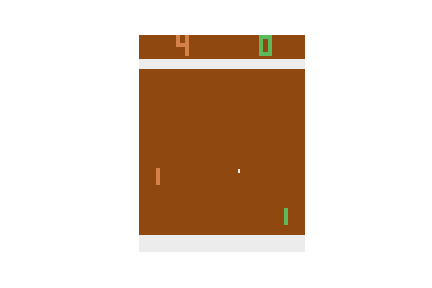
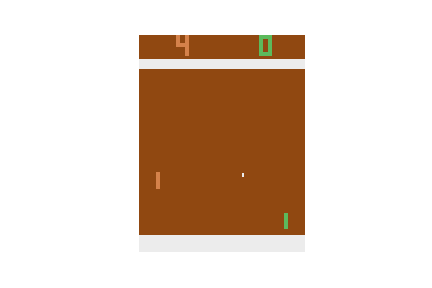
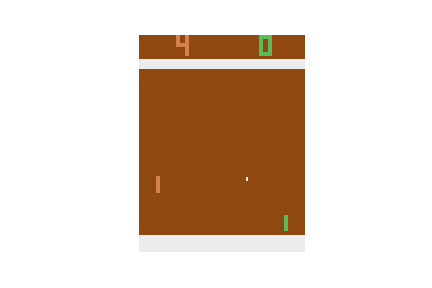
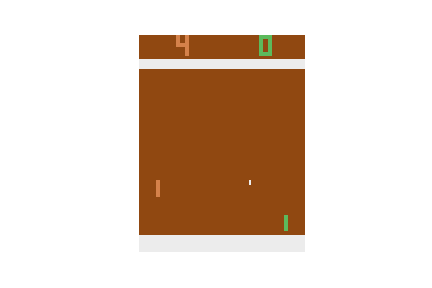
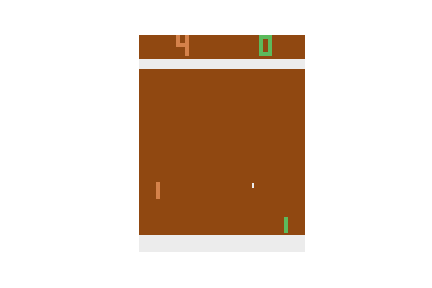
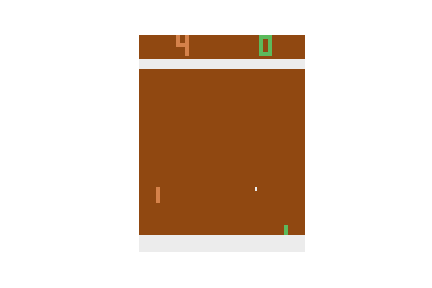
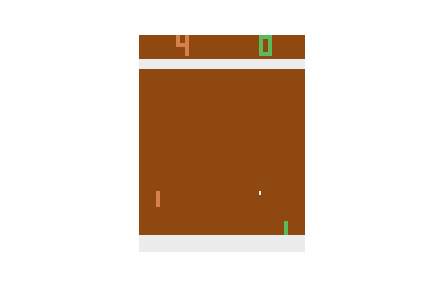
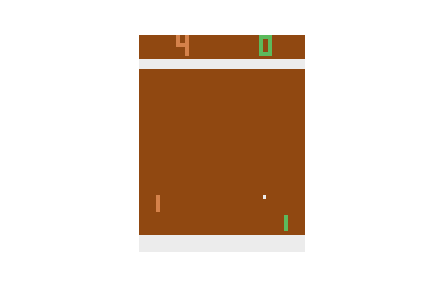
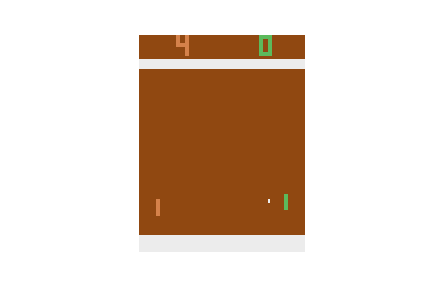
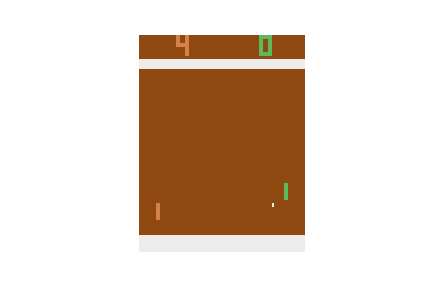
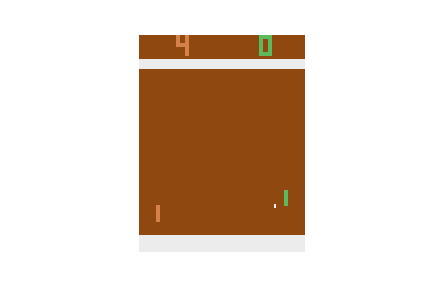
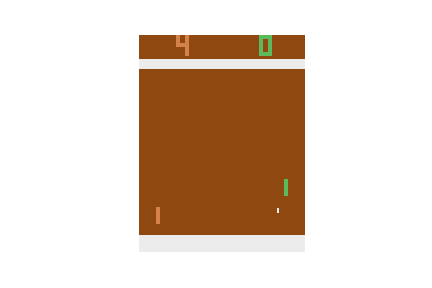
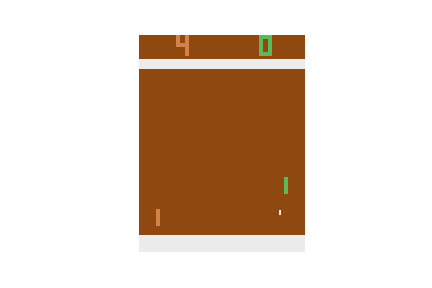
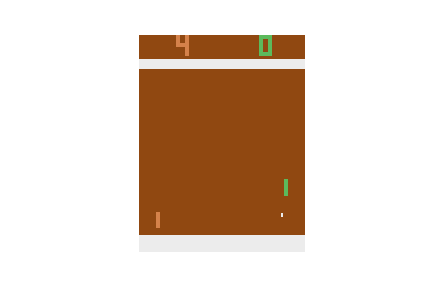
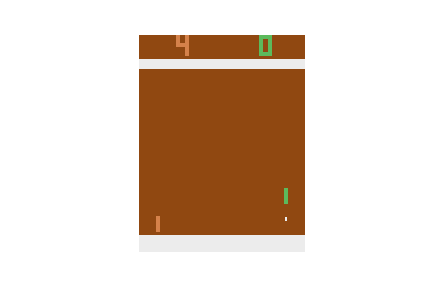
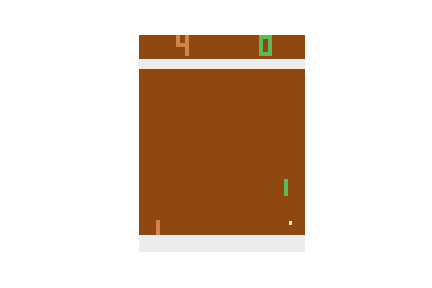
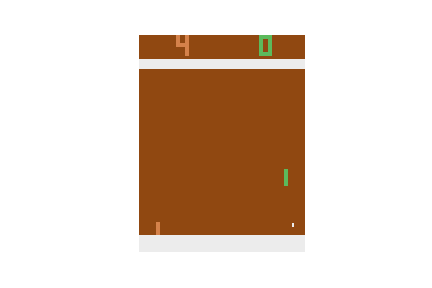
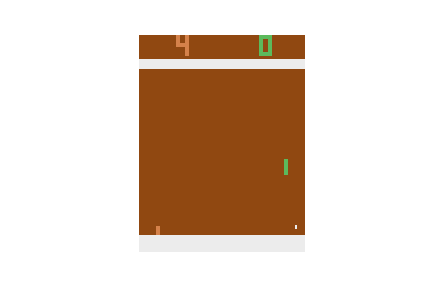
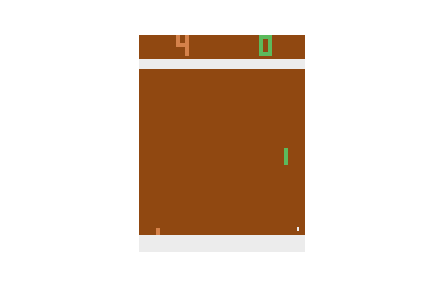
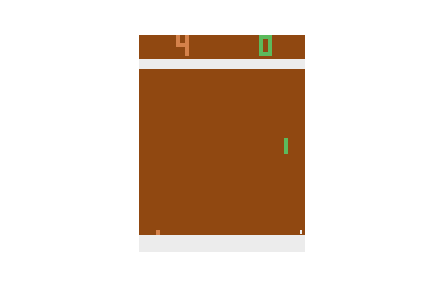
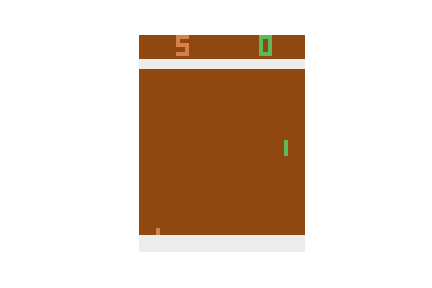
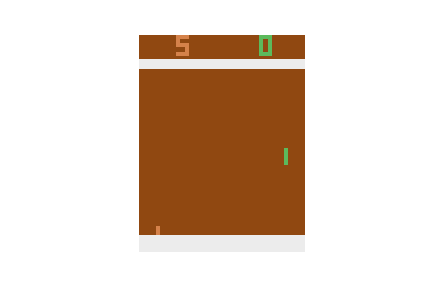
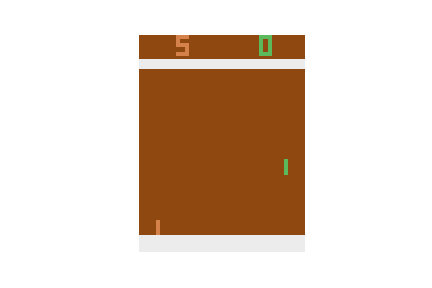
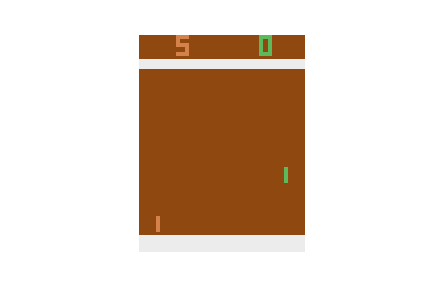
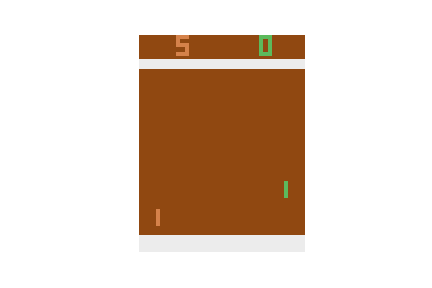
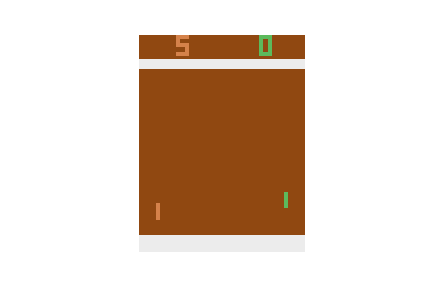
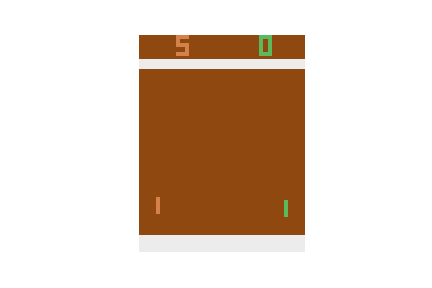
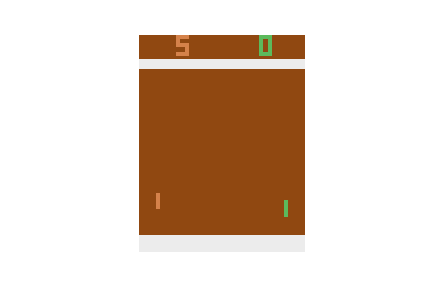
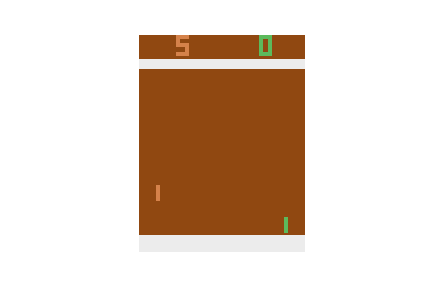
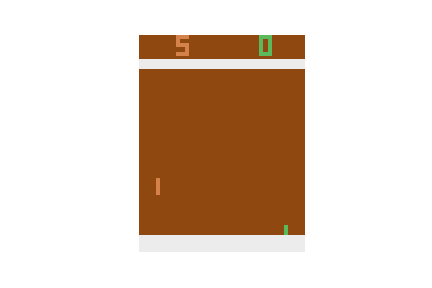
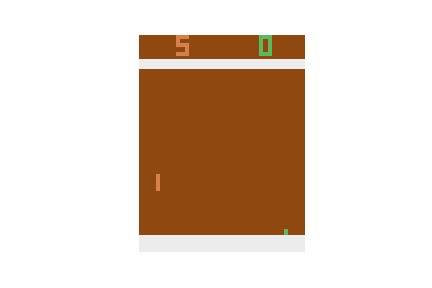
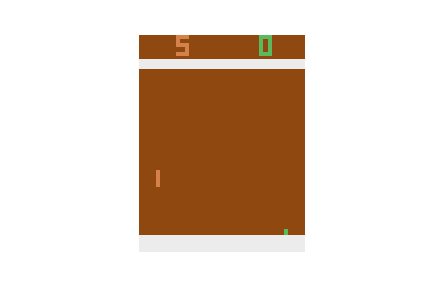
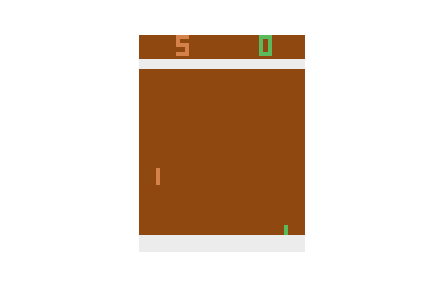
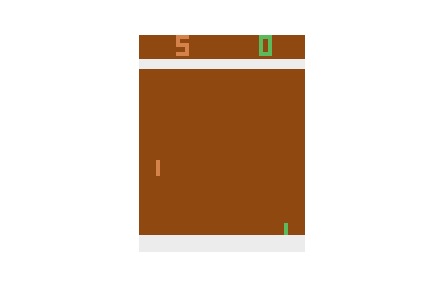
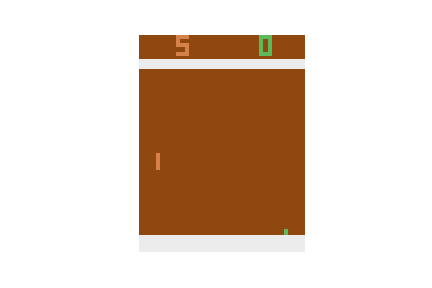
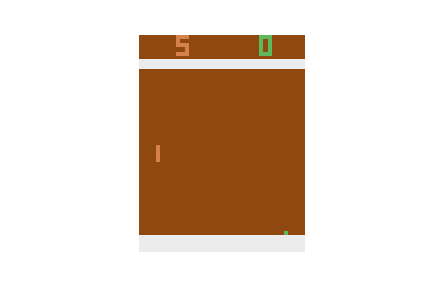
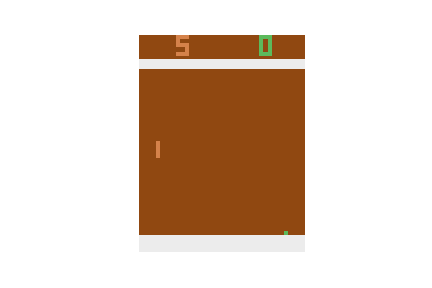
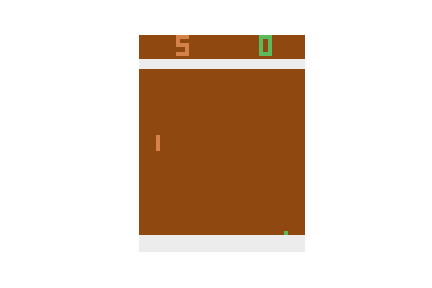
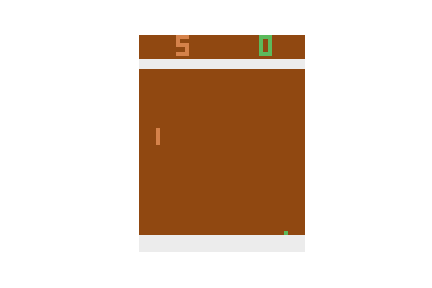
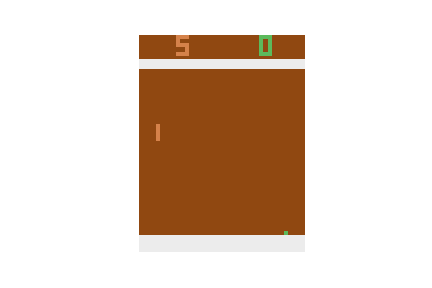
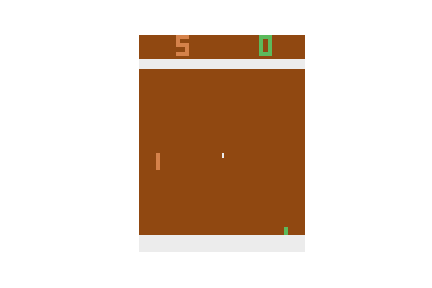
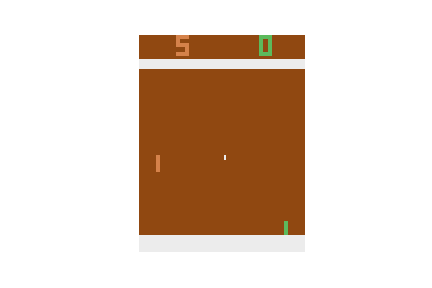
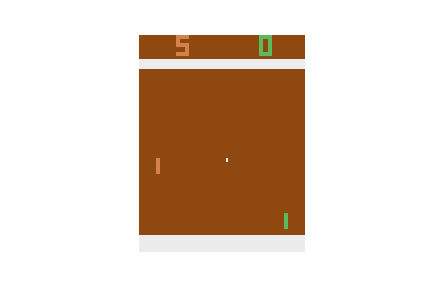
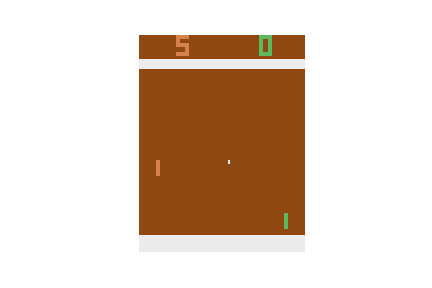
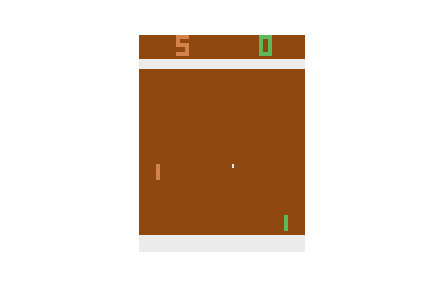
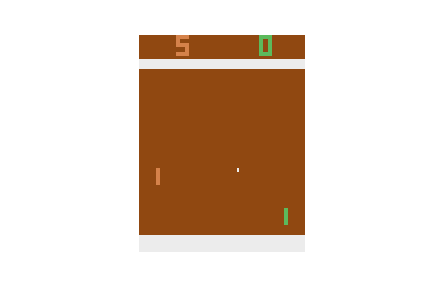
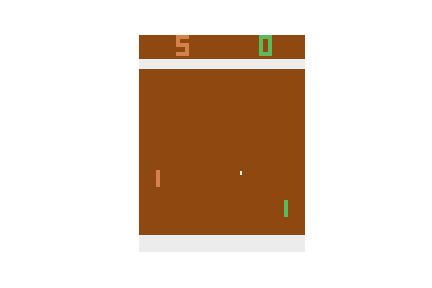
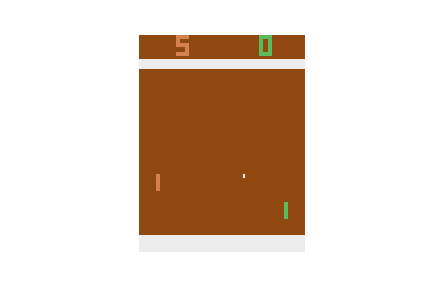
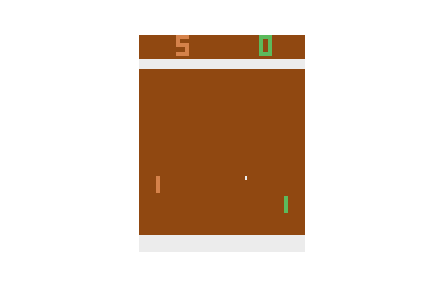
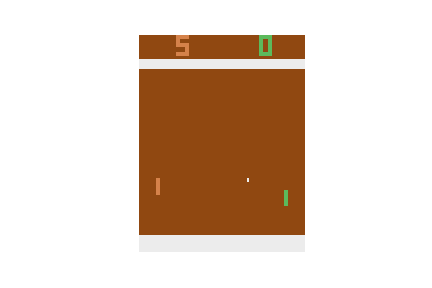
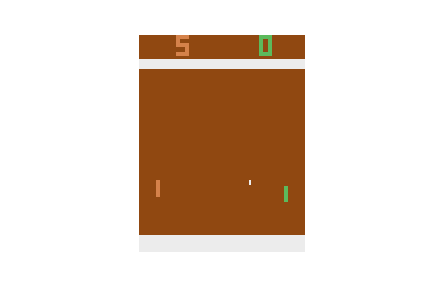
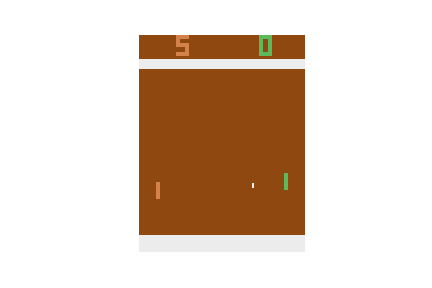
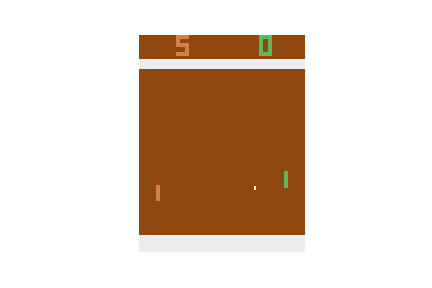
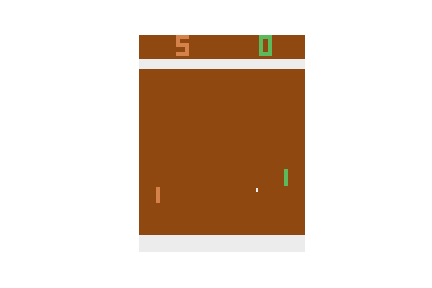

In [62]:
import matplotlib.animation as animation
from JSAnimation.IPython_display import display_animation
from IPython.display import display

fig = plt.figure()
patch = plt.imshow(video[0])
plt.axis('off')

def animate(idx):
    patch.set_data(video[idx])
    
anim = animation.FuncAnimation(plt.gcf(), animate,
                               frames=len(video), interval=30)

display(display_animation(anim))